# EDA: Bird Song Identification

'Gold Team' members:
- Max Song
- Joseph Trybala
- Jonathan Watkins

# Features

### Numerical
- Bitrate_of_mp3: 
    - Numerical, Continuous //  The bitrate at which the MP3 file is encoded, provided in kbps (kilobits per second)
- Duration:
    - Numerical, Continuous // The recording length as measured in seconds (per minute). Within the metadata file, the number of seconds is always reported as a whole number and not rounded up at all, e.g. a recording with a duration of 1.9s is still counted as having a length of 1 in the .csv file.  Some recordings (40 in total) values are zeroes but a manual search on xeno-canto points confirms these are typically between 0.5s and .9s in length. 
- Elevation: 
    - Numerical, Continuous // The elevation at which the recording was made. The data points in the elevation column contained several anomalies in terms of types of entry that needed to be cleaned for proper use. Refer to the notebook for visuals and more specifics. Outliers need to be taken under the microscope here as the min. e.g. does not appear correct as the recording was done in Texas (not -3670 m. below sea level) and the max 7760(m) in Utah, which is not the case.
- Latitude: 
    - Numerical, Continuous // Combined with longitude, this geolocates our point of recording.
- Longitude:
    - Numerical, Continuous // Combined with latitude, this geolocates our point of recording.
- Ratings: 
    - The ratings in this dataset are for the recordings. Ratings per recording are an averaged value from a community rating process. (See Duration note in appendix)
    - Fom updated xeno-canto rating guideline (https://xeno-canto.org/help/FAQ#rating):
        - A: Loud and Clear
        - B: Clear, but the animal is a bit distant, or some interference with other sound sources
        - C: Moderately clear, or quite some interference
        - D: Faint recording, or much interference
        - E: Barely audible

- Sampling_rate: 
    - Numerical, Continuous // The number of samples of audio recorded per second measured in Hertz (Hz). It determines the frequency range and the quality of the audio recording, where higher sampling rates translate to higher resolution fidelity and capturing more details of the sound (by capturing more data).

### Categorical
- Author: 
    - Categorical, Nominal // The name of the author of the audio clip, the recordist in Xeno-Canto terminology
- Background: 
    - Categorical, Nominal // A list of species found in addition to the target species in the background of the audio clip.
- Bird_seen: 
    - Categorical, Nominal // A true or false value, truth indicates that the recordist made visual identification of the individual making the call
- Channels: 
    - Categorical, Nominal // Either 1(mono) or 2 (stereo) used to record the birds for playback purposes. No more in-depth exploration was done. 
- Country: 
    - Categorical, Nominal // The country where the recording is located
- Date: 
    - Categorical, Nominal // The date of recording
- File_type: 
    - Categorical, Nominal // A singular value represents the whole dataset, .mp3.
- Filename: 
    - Categorical, Nominal // A combination of the XC_ID and the file_type. Inconsequential for us.
- License: 
    - Categorical, Nominal // Type of license with which the data was provided
- Location: 
    - Categorical, Nominal // The local town, park, or proper place at which the data is recorded. Varying degrees of geographical information are given. 
- Playback_used: 
    - Categorical, Nominal // If yes, the recordist/author used a synthetic “pre-recorded” bird call of the same species to elicit calls/song/chirps, etc. from the bird being pursued. Additional: playback is a technique used by birders to elicit bird calls from birds that don't usually come out as often and for other reasons (e.g., mating, and birds calling to protect territory) (https://www.sibleyguides.com/2011/04/the-proper-use-of-playback-in-birding/)
- Primary_label: 
    - Categorical, Nominal // The primary species represented in the recording
recordist: 
    - Categorical, Nominal // Same value as Author
- Sci_name: 
    - Categorical, Nominal // Scientific name of the primary species of the recording
- Secondary_labels: 
    - Categorical, Nominal // Same value as Background
- Species: 
    - Categorical, Nominal // Same value as Background
- Time: 
    - Date/Time (or Categorical, Nominal if descriptive), both are found in our dataset. The vast majority are found in Date/Time. While not as easy, we feel as though date/time provides too much to convert to categorical. We are setting all data to Date/Time numerical by finding average times per am/pm, and then setting all AM or PM values to the average.
- Title:
    -  Categorical, Nominal // Same value as XC_ID
- Type:
    -  Categorical, Nominal // What type of sound was recorded, descriptive, could contain labelling of sex
- Url: 
    - Categorical, Nominal // Uses XC_ID to direct to the URL origin of the audio data
- Xc_id: 
    - Categorical, Nominal // The unique ID that Xeno-Canto provides for the audio clip

### Irrelevant Features
- Ebird_code: 
    - Categorical, Nominal // A shortened form of the species name, serving as a form of a unique ID. Irrelevant to our purposes.
- Recordist: 
    - Categorical, Nominal // Same as Author. Duplicate data

In [1]:
# %load_ext cudf.pandas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import random
from dateutil import parser

sns.set_style("whitegrid")

In [2]:
A_Z_df = pd.read_csv("./train_extended.csv") # csv within save directory

In [3]:
A_Z_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23784 entries, 0 to 23783
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rating            23784 non-null  float64
 1   playback_used     21938 non-null  object 
 2   ebird_code        23784 non-null  object 
 3   channels          23784 non-null  object 
 4   date              23784 non-null  object 
 5   duration          23784 non-null  int64  
 6   filename          23784 non-null  object 
 7   species           23784 non-null  object 
 8   title             23784 non-null  object 
 9   secondary_labels  23784 non-null  object 
 10  bird_seen         21827 non-null  object 
 11  sci_name          23784 non-null  object 
 12  location          23784 non-null  object 
 13  latitude          23359 non-null  float64
 14  sampling_rate     23784 non-null  object 
 15  type              23755 non-null  object 
 16  elevation         23784 non-null  object

In [4]:
A_Z_df.head()

rating playback_used ebird_code    channels        date  duration  \
0     0.0            no     aldfly  2 (stereo)  2019-06-11        49   
1     0.0            no     aldfly  2 (stereo)  2020-04-14        21   
2     0.0           yes     aldfly  2 (stereo)  2020-04-05        35   
3     0.0           yes     aldfly  2 (stereo)  2020-04-05        12   
4     0.0           yes     aldfly  2 (stereo)  2020-04-05        38   

       filename           species  \
0  XC554809.mp3  Alder Flycatcher   
1  XC552408.mp3  Alder Flycatcher   
2  XC544552.mp3  Alder Flycatcher   
3  XC544551.mp3  Alder Flycatcher   
4  XC544550.mp3  Alder Flycatcher   

                                           title secondary_labels  ...  \
0  XC554809 Alder Flycatcher (Empidonax alnorum)               []  ...   
1  XC552408 Alder Flycatcher (Empidonax alnorum)               []  ...   
2  XC544552 Alder Flycatcher (Empidonax alnorum)               []  ...   
3  XC544551 Alder Flycatcher (Empidonax alnorum)               []  ...   
4  XC544550 Alder Flycatcher (Empidonax alnorum)               []  ...   

  background   xc_id                                url        country  \
0        NaN  554809  https://www.xeno-canto.org/554809  United States   
1        NaN  552408  https://www.xeno-canto.org/552408       Colombia   
2        NaN  544552  https://www.xeno-canto.org/544552       Colombia   
3        NaN  544551  https://www.xeno-canto.org/544551       Colombia   
4        NaN  544550  https://www.xeno-canto.org/544550       Colombia   

           author                       primary_label longitude   time  \
0   Ron Overholtz  Empidonax alnorum_Alder Flycatcher -149.9757  07:00   
1  Jerome Fischer  Empidonax alnorum_Alder Flycatcher  -74.6520  17:00   
2  Jerome Fischer  Empidonax alnorum_Alder Flycatcher  -74.6520  07:00   
3  Jerome Fischer  Empidonax alnorum_Alder Flycatcher  -74.6520  07:00   
4  Jerome Fischer  Empidonax alnorum_Alder Flycatcher  -74.6520  07:00   

        recordist                                            license  
0   Ron Overholtz  Creative Commons Attribution-NonCommercial-Sha...  
1  Jerome Fischer  Creative Commons Attribution-NonCommercial-Sha...  
2  Jerome Fischer  Creative Commons Attribution-NonCommercial-Sha...  
3  Jerome Fischer  Creative Commons Attribution-NonCommercial-Sha...  
4  Jerome Fischer  Creative Commons Attribution-NonCommercial-Sha...  

[5 rows x 29 columns]

## Bar Plot of Variables

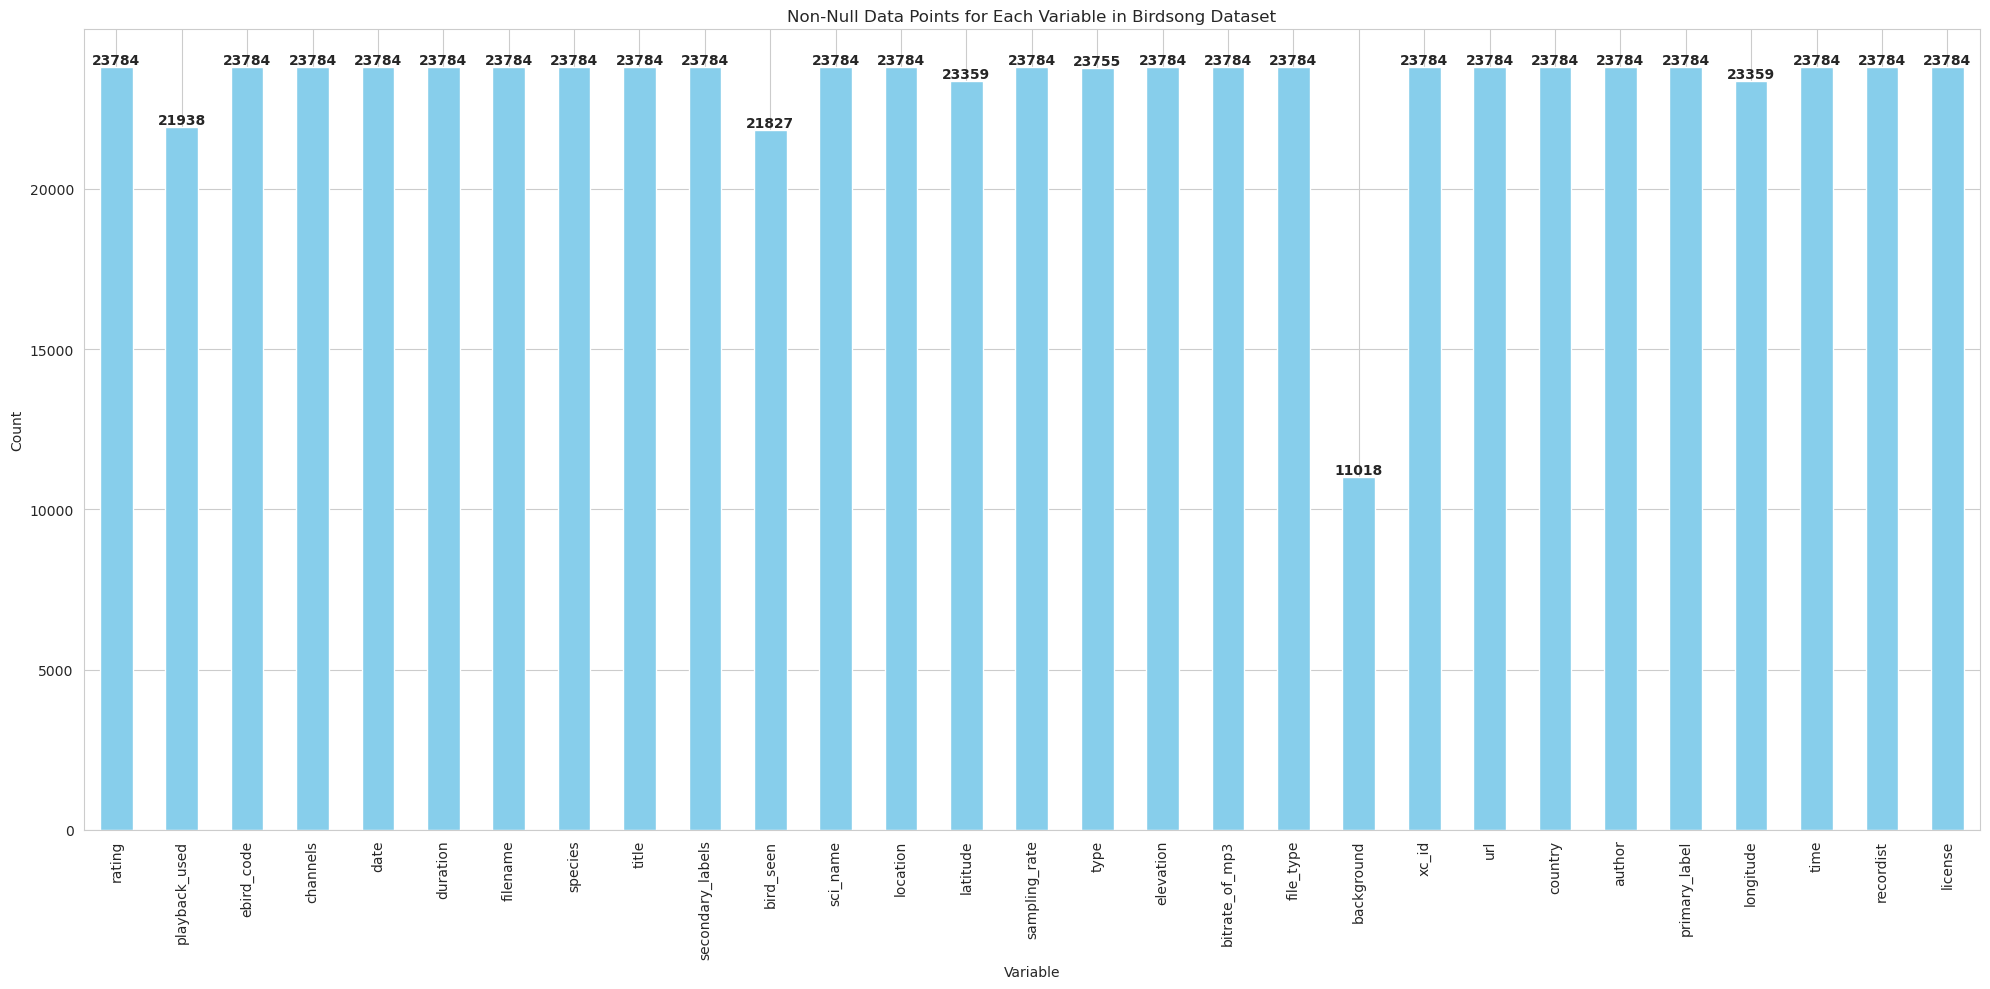

In [5]:
# counting non-null entries for each column(variable)
non_null_counts = A_Z_df.count()

# plotting the non-null counts
plt.figure(figsize=(20, 10))
non_null_counts.plot(kind='bar', color='skyblue')
plt.title('Non-Null Data Points for Each Variable in Birdsong Dataset')
plt.xlabel('Variable')
plt.ylabel('Count')
plt.xticks(rotation=90)

# adding annotations
for index, value in enumerate(non_null_counts):
    plt.text(index, value, str(value), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Missing Value Analysis

- latitude/longitude (removed)        
- background (imputed)                
- type (removed)                      
- bird_seen (imputed)                
- playback_used (imputed)        
- date (imputed)

In [6]:
# loading in original dataset
A_Z_df2 = pd.read_csv("./train_extended.csv")

#### Percentage of missing values

In [7]:
# percentage of missing values for latitude/longitude (one is enough, because they are the same recordings)
missing_lat = A_Z_df2['latitude'].isnull()
missing_lat_count = missing_lat.sum()
missing_lat_long_percent = (missing_lat_count / len(A_Z_df2)) * 100
print(f"The number of missing latitude/longitude is:", missing_lat_count)
print(f"The percentage of missing values of latitude and longitude are:", missing_lat_long_percent)

The number of missing latitude/longitude is: 425
The percentage of missing values of latitude and longitude are: 1.7869155734947864


In [8]:
# percentage of missing values in background
missing_bg = A_Z_df2['background'].isnull()
missing_bg_count = missing_bg.sum()
missing_bg_percent = (missing_bg_count / len(A_Z_df2)) * 100
print(f"The number of missing background values are:", missing_bg_count)
print(f"The percentage of missing values of background are:", missing_bg_percent)

The number of missing background values are: 12766
The percentage of missing values of background are: 53.67473932055164


In [9]:
# percentage of missing values in type
missing_type = A_Z_df2['type'].isnull()
missing_type_count = missing_type.sum()
missing_type_percent = (missing_type_count / len(A_Z_df2)) * 100
print(f"The number of missing type is:", missing_type_count)
print(f"The percentage of missing values of type are:", missing_type_percent)

The number of missing type is: 29
The percentage of missing values of type are: 0.12193070972082072


In [10]:
# percentage of missing values in bird_seen
missing_bird_seen = A_Z_df2['bird_seen'].isnull()
missing_bird_seen_count = missing_bird_seen.sum()
missing_bird_seen_percent = (missing_bird_seen_count / len(A_Z_df2)) * 100
print(f"The number of missing bird seen values are:", missing_bird_seen_count)
print(f"The percentage of missing values of bird_seen are:", missing_bird_seen_percent)

The number of missing bird seen values are: 1957
The percentage of missing values of bird_seen are: 8.228220652539523


In [11]:
# percentage of missing values in playback_used
missing_playback_used = A_Z_df2['playback_used'].isnull()
missing_playback_used_count = missing_playback_used.sum()
missing_playback_used_percent = (missing_playback_used_count / len(A_Z_df2)) * 100
print(f"The number of missing playback used values are:", missing_playback_used_count)
print(f"The percentage of missing values of playback_used are:", missing_playback_used_percent)

The number of missing playback used values are: 1846
The percentage of missing values of playback_used are: 7.761520349815002


In [12]:
# percentage of missing values in date (these missing values are labeled as '0000-00-00')

# replacing all values that are 0000-00-00 with NaN
A_Z_df2['date'] = A_Z_df2['date'].replace('0000-00-00', np.nan)
missing_date = A_Z_df2['date'].isnull()
missing_date_count = missing_date.sum()
missing_date_percent = (missing_date_count / len(A_Z_df2)) * 100
print(f"The number of missing dates are:", missing_date_count)
print(f"The percentage of missing values of date are:", missing_date_percent)

The number of missing dates are: 23
The percentage of missing values of date are: 0.0967036663303061


applying the cleanup function to elevation feature; missing values are slightly higher because recordings from other rows with missing values have not yet been dropped. From new dataset, there are 1329 missing values. After dropping other missing rows, number of elevation rows missing: 970.

In [13]:
# applying the cleanup function to elevation feature
# missing values are slightly higher because recordings from other rows with missing values have not yet been dropped.
# from original dataset, there are 1329 missing values. 
# after dropping other missing rows, number of elevation rows missing: 970.

# Function for cleaning and processing messy elevation values
def clean_elevation(elevation):
    if pd.isna(elevation):
        return None
    elevation = str(elevation).lower().strip()
    if 'unknown' in elevation:
        return None

    # Handle ranges of elevation with two numbers and a '-' in between
    if '-' in elevation:
        parts = re.split(r'\s*-\s*', elevation)
        try:
            numbers = [float(re.sub(r'[^\d.-]', '', part)) for part in parts if re.sub(r'[^\d.-]', '', part)]
            if len(numbers) == 2:
                return int(round(sum(numbers) / len(numbers)))
        except ValueError:
            return None

    # Get rid of any non-numeric characters and convert to float
    elevation = re.sub(r'[^\d.-]', '', elevation)
    try:
        elevation = float(elevation)
        return int(round(elevation))
    except ValueError:
        return None
    
# Apply function to the column 'elevation'
A_Z_df2['elevation'] = A_Z_df2['elevation'].apply(clean_elevation)

In [14]:
# percentage of missing values for elevation
missing_elevation = A_Z_df2['elevation'].isnull()
missing_elevation_count = missing_elevation.sum()
missing_elevation_percent = (missing_elevation_count / len(A_Z_df2)) * 100
print(f"The number of missing elevations is:", missing_elevation_count)
print(f"The percentage of missing values of elevation are:", missing_elevation_percent)

The number of missing elevations is: 1329
The percentage of missing values of elevation are: 5.5877901109989905


# Missing Value Removal

### Background: Imputing with 'None'
- If null, count background species as 0. Otherwise count the number of species.

In [15]:
# populating all missing values in background column with None
A_Z_df = A_Z_df.fillna({'background': 'None'})

In [16]:
A_Z_df['background'].value_counts()

background
None                                                                                                        12766
Red-winged Blackbird (Agelaius phoeniceus)                                                                    150
American Robin (Turdus migratorius)                                                                           134
House Sparrow (Passer domesticus)                                                                             122
Song Sparrow (Melospiza melodia)                                                                              109
                                                                                                            ...  
European Starling (Sturnus vulgaris); Fieldfare (Turdus pilaris)                                                1
Eurasian Tree Sparrow (Passer montanus); Fieldfare (Turdus pilaris)                                             1
Eurasian Collared-Dove (Streptopelia decaocto); Swan Goose (Anser cygnoides);

### Dates: (0000-00-00)

In [17]:
earliest_date = A_Z_df['date'].min()
latest_date = A_Z_df['date'].max()

print(f"Earliest Date: {earliest_date}")
print(f"Latest Date: {latest_date}")

Earliest Date: 0000-00-00
Latest Date: 2020-09-13


In [18]:
zero_dates = A_Z_df[A_Z_df['date'] == '0000-00-00']
num_zero_dates = len(zero_dates)

print("Number of zero (missing) dates:", num_zero_dates)

Number of zero (missing) dates: 23


In [19]:
# replace all values that are 0000-00-00 with NaN
A_Z_df['date'] = A_Z_df['date'].replace('0000-00-00', np.nan)
A_Z_df['date']

0        2019-06-11
1        2020-04-14
2        2020-04-05
3        2020-04-05
4        2020-04-05
            ...    
23779    2020-05-16
23780    2020-07-27
23781    2020-07-10
23782    2020-07-03
23783    2020-06-04
Name: date, Length: 23784, dtype: object

In [20]:
# find all cases of NaN's in 'date' column
missing_dates = A_Z_df[A_Z_df['date'].isnull()]
print(len(missing_dates))

23


Looking into the bottom 50% (half) of species within dataset.

In [21]:
# which bird species are of those missing from bird-seen
missing_date = A_Z_df[A_Z_df['date'].isnull()]['species']

In [22]:
# see if any values in missing_date are in the bottom 50% of 'A_Z_df['species']'
# if species in the bottom half are missing, we shouldn't remove them and impute somehow (using a distribution of the current yes-no values for date)

# getting the bottom 50% of species
species_counts = A_Z_df['species'].value_counts() # get the counts of each species
bottom_50_percent = species_counts.quantile(0.5) # get the value at the 50th percentile
bottom_species_50 = species_counts[species_counts <= bottom_50_percent].index # get the species that are in the bottom half

This means that in the bottom half of the dataset, there are no recordings with missing dates (0000-00-00).
Good justification for removing missing dates

In [23]:
# check if missing_date contains any of the bottom species
missing_date_bottom_species = missing_date[missing_date.isin(bottom_species_50)]
print(len(missing_date_bottom_species))

0


In [24]:
# remove all missing values from date column
A_Z_df = A_Z_df.dropna(subset=['date'])

In [25]:
#check if there are missing values in date column
A_Z_df['date'].isnull().sum()

0

Transforming Dates (cleanup)

missing months

In [26]:
# there are three instances where the month is unknown: '2009-00-20' and '2020-00-02' and '2001-00-00'.
# for the first two cases: '2009-00-02' and '2020-00-02', make the month: '01'
# for the last case: '2001-00-00', make the month: '01' and the date: '01'

# deal with all cases of when the month is '00'
A_Z_df['date'] = A_Z_df['date'].replace('2009-00-20', '2009-01-20')
A_Z_df['date'] = A_Z_df['date'].replace('2020-00-02', '2020-01-02')
A_Z_df['date'] = A_Z_df['date'].replace('2001-00-00', '2001-01-01')

missing days

In [27]:
# there are many cases where the day is unknown: ex: '2009-08-00'
# for all cases where the day is unknown, make the day: '01'
A_Z_df['date'] = A_Z_df['date'].apply(lambda x: x[:8] + '01' if x[8:] == '00' else x)

### Latitude/Longitutde: Removing NaN

- Removed Missings (losing 425 rows)
- We decided to just drop these. We can always come back and impute them if needed.
- Two approaches were thought of: getting the lat/long based on country-species-date OR using an API to manually gather lat/long based on locations

In [28]:
A_Z_df = A_Z_df.dropna(subset=['latitude', 'longitude'])

### Type: Removing NaN

- Removed Missing (losing 29 rows)
- supporting evidence: very few number of rows to remove;
- type is something indicated by the recordist/author, so we really can't impute

In [29]:
A_Z_df = A_Z_df.dropna(subset=['type'])

### Bird-Seen: Imputing

- There are 1880 rows and we think this is too many rows to remove, so we are imputing via proportion (yes-no) ~25% no, ~75% yes

#### Supporting Evidence to support decisions surrounding missing values in bird-seen column

In [30]:
A_Z_df['species'].value_counts()

species
Red Crossbill                1758
House Sparrow                1208
House Wren                    945
Northern Raven                878
Common Starling               688
                             ... 
Ring-necked Duck                1
Bufflehead                      1
Hooded Merganser                1
Black-chinned Hummingbird       1
Ruffed Grouse                   1
Name: count, Length: 259, dtype: int64

In [31]:
# Getting the value counts for the species
species_counts = A_Z_df['species'].value_counts()

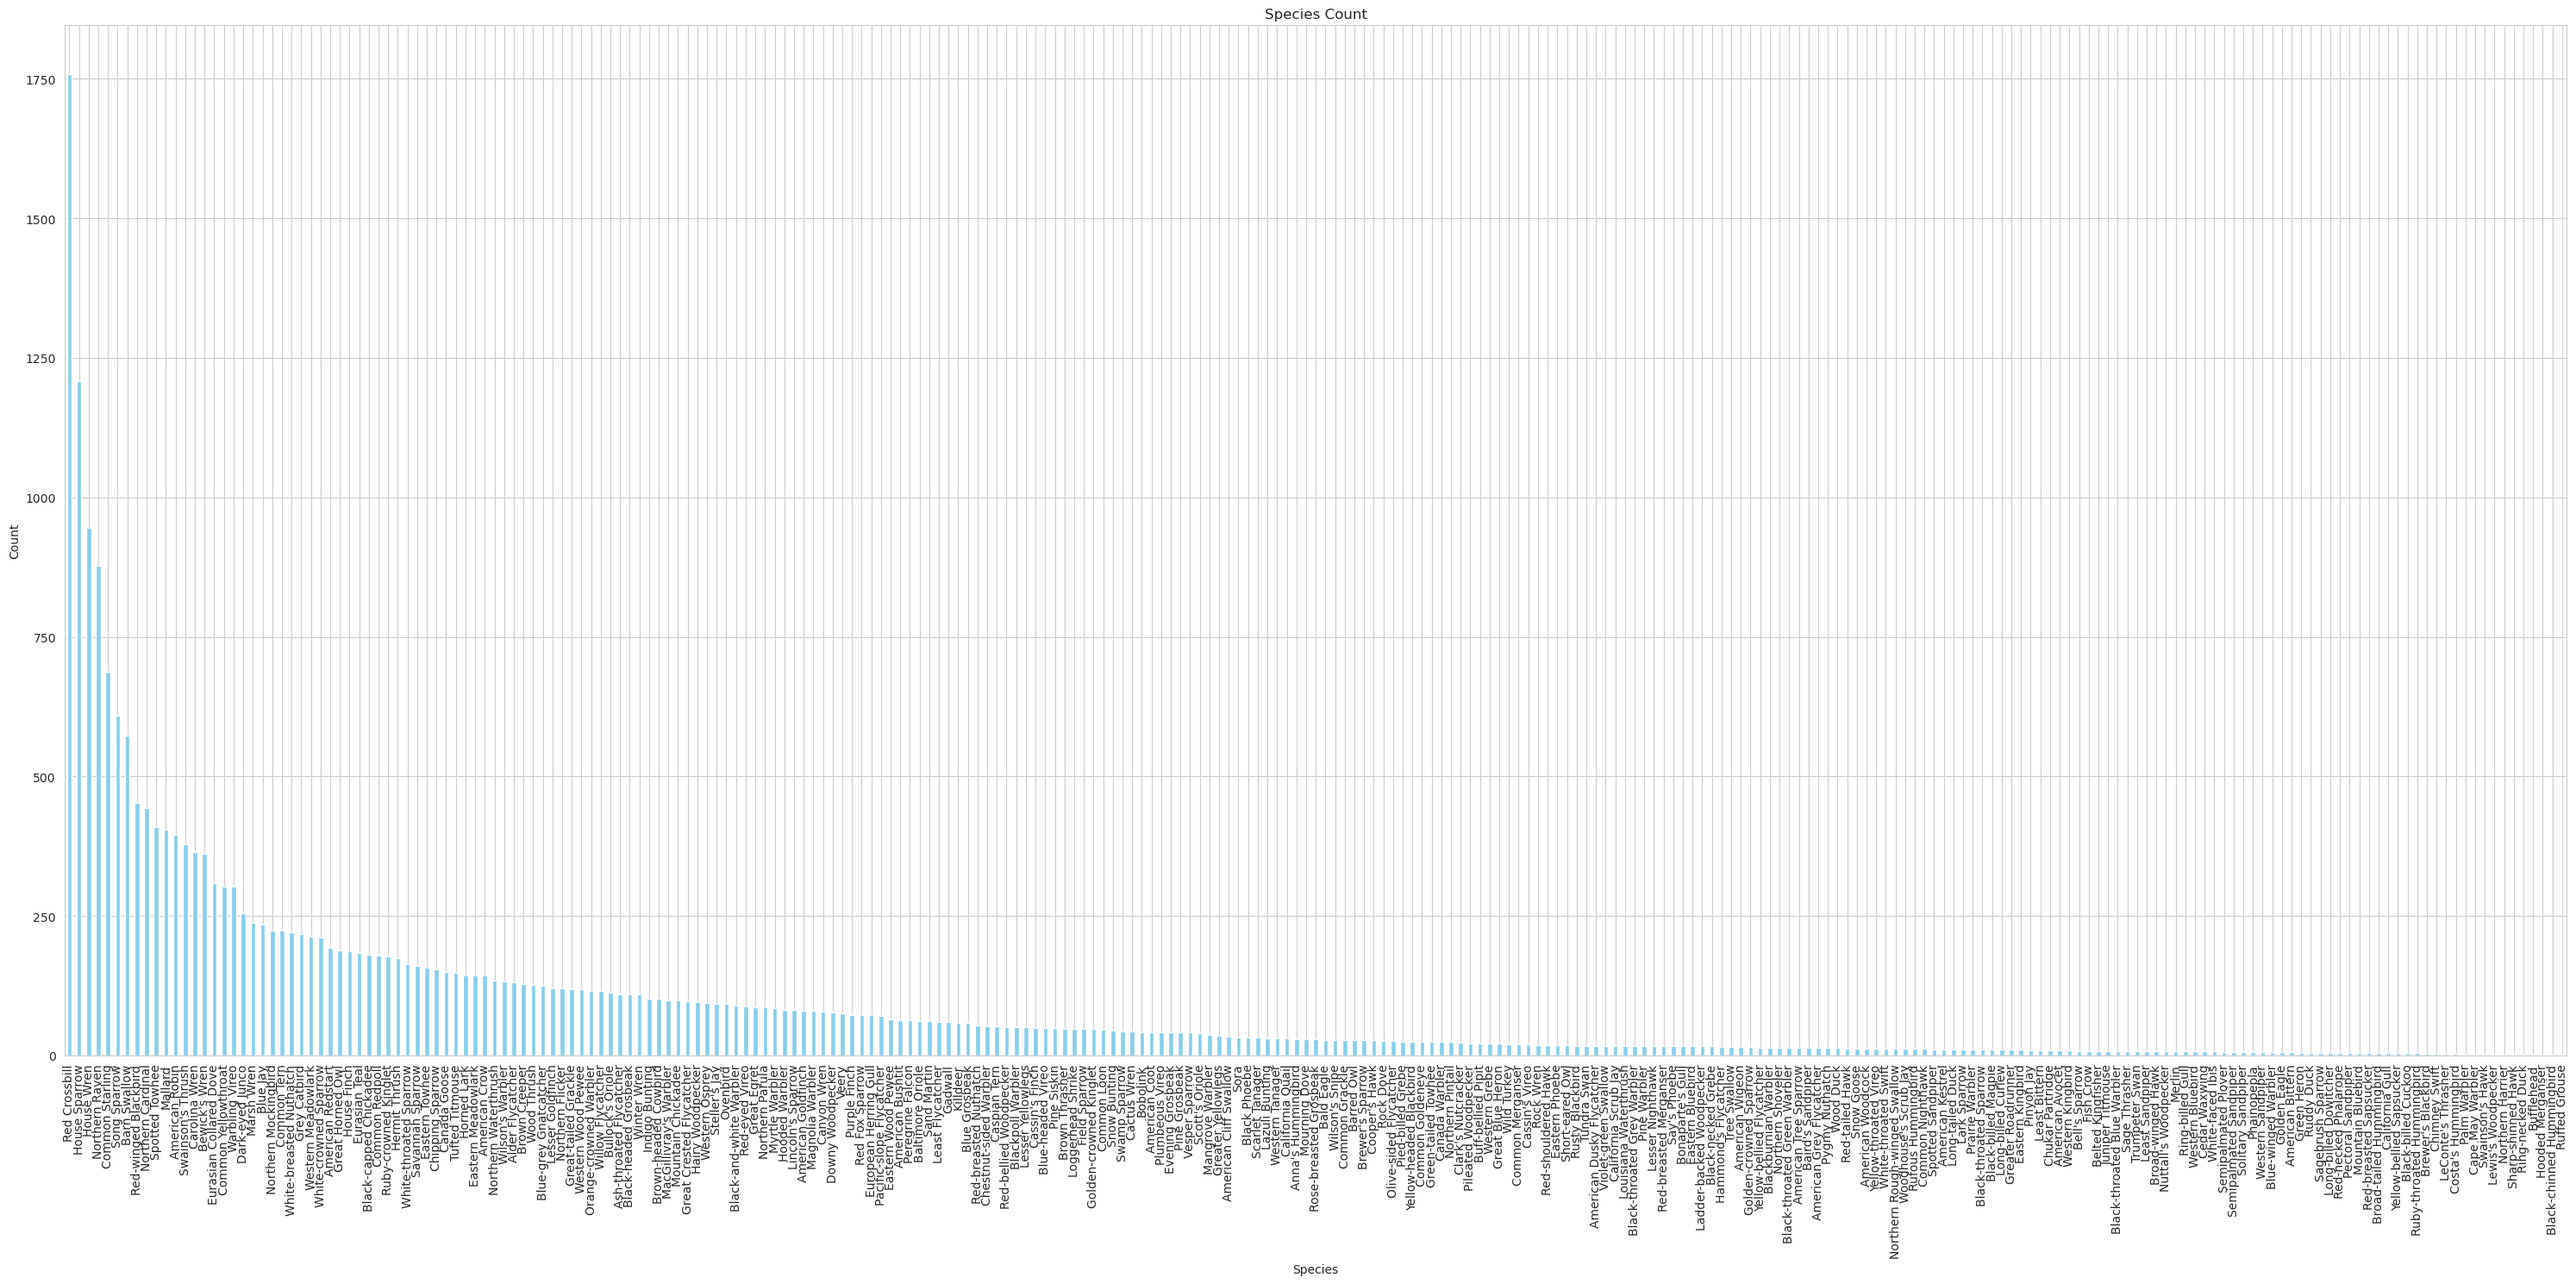

In [32]:
# Plotting the value counts
plt.figure(figsize=(30, 15))
species_counts.plot(kind='bar', color='skyblue')
plt.title('Species Count')
plt.xlabel('Species')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

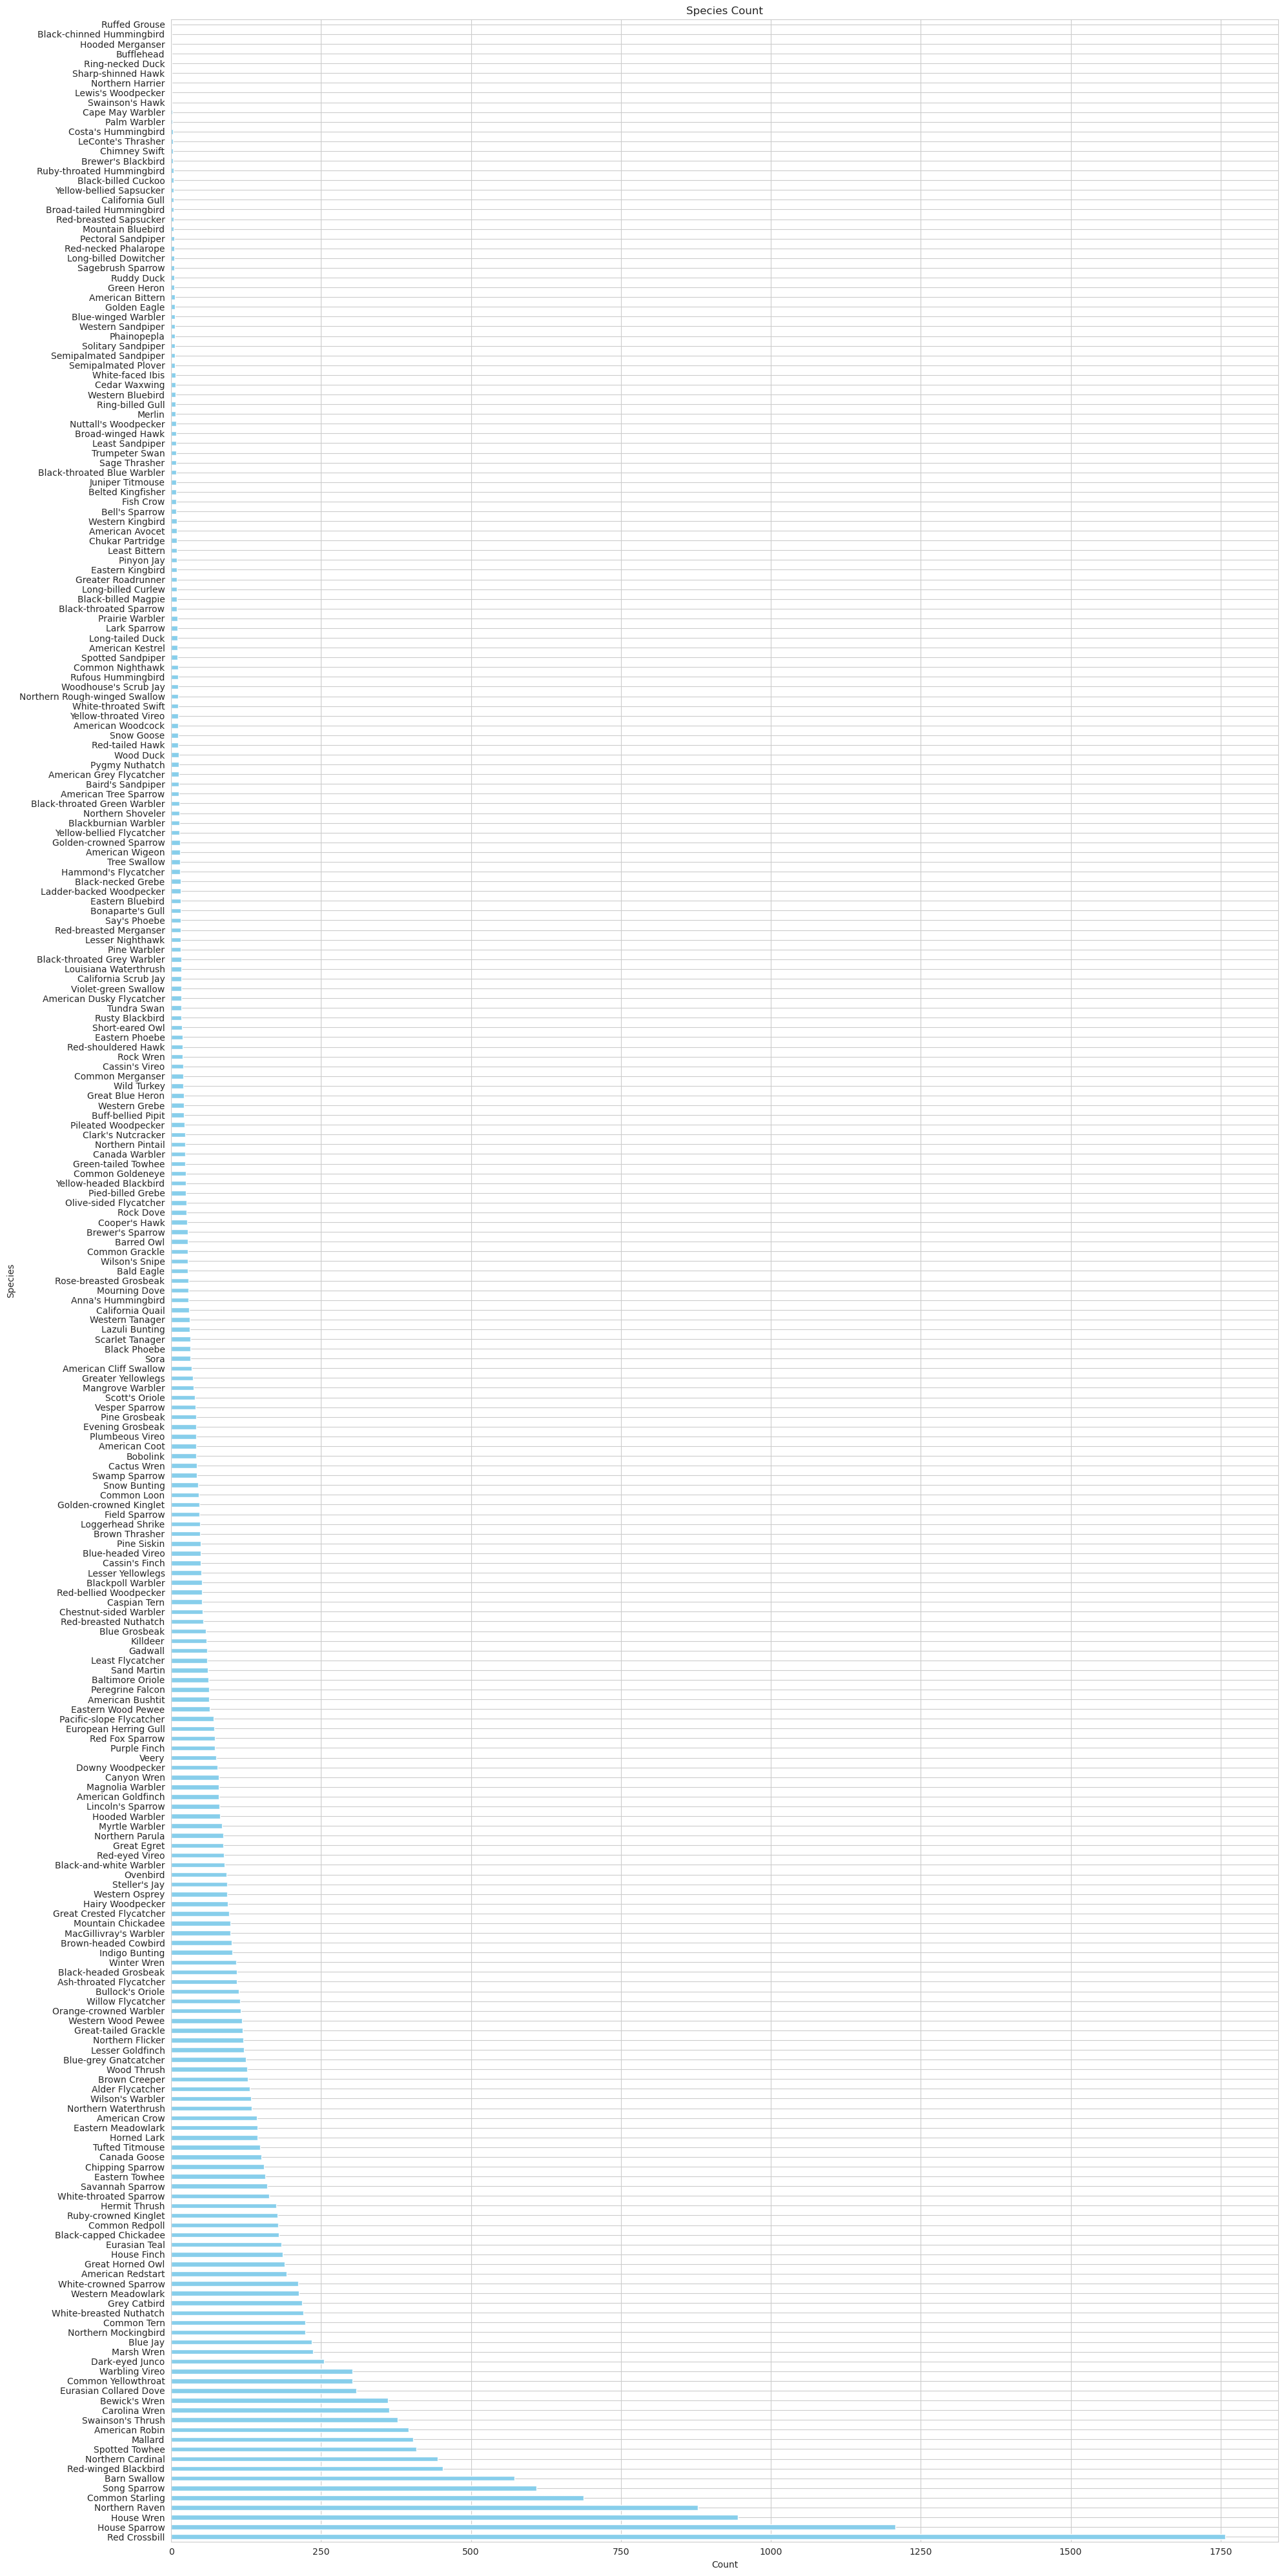

In [33]:
plt.figure(figsize=(20, 40))
species_counts.plot(kind='barh', color='skyblue')
plt.title('Species Count')
plt.xlabel('Count')
plt.ylabel('Species')
plt.tight_layout()
plt.show()

In [34]:
# which bird species are of those missing from bird-seen
missing_bird_seen = A_Z_df[A_Z_df['bird_seen'].isnull()]['species']

In [35]:
# we can see that most of the species that are missing from the bird-seen column are groups that are well represented
missing_bird_seen.value_counts()

species
Red Crossbill               145
House Wren                  121
Barn Swallow                 88
House Sparrow                59
Song Sparrow                 57
                           ... 
Barred Owl                    1
Broad-winged Hawk             1
Yellow-bellied Sapsucker      1
Yellow-headed Blackbird       1
Buff-bellied Pipit            1
Name: count, Length: 157, dtype: int64

In [36]:
missing_birds = missing_bird_seen.value_counts()

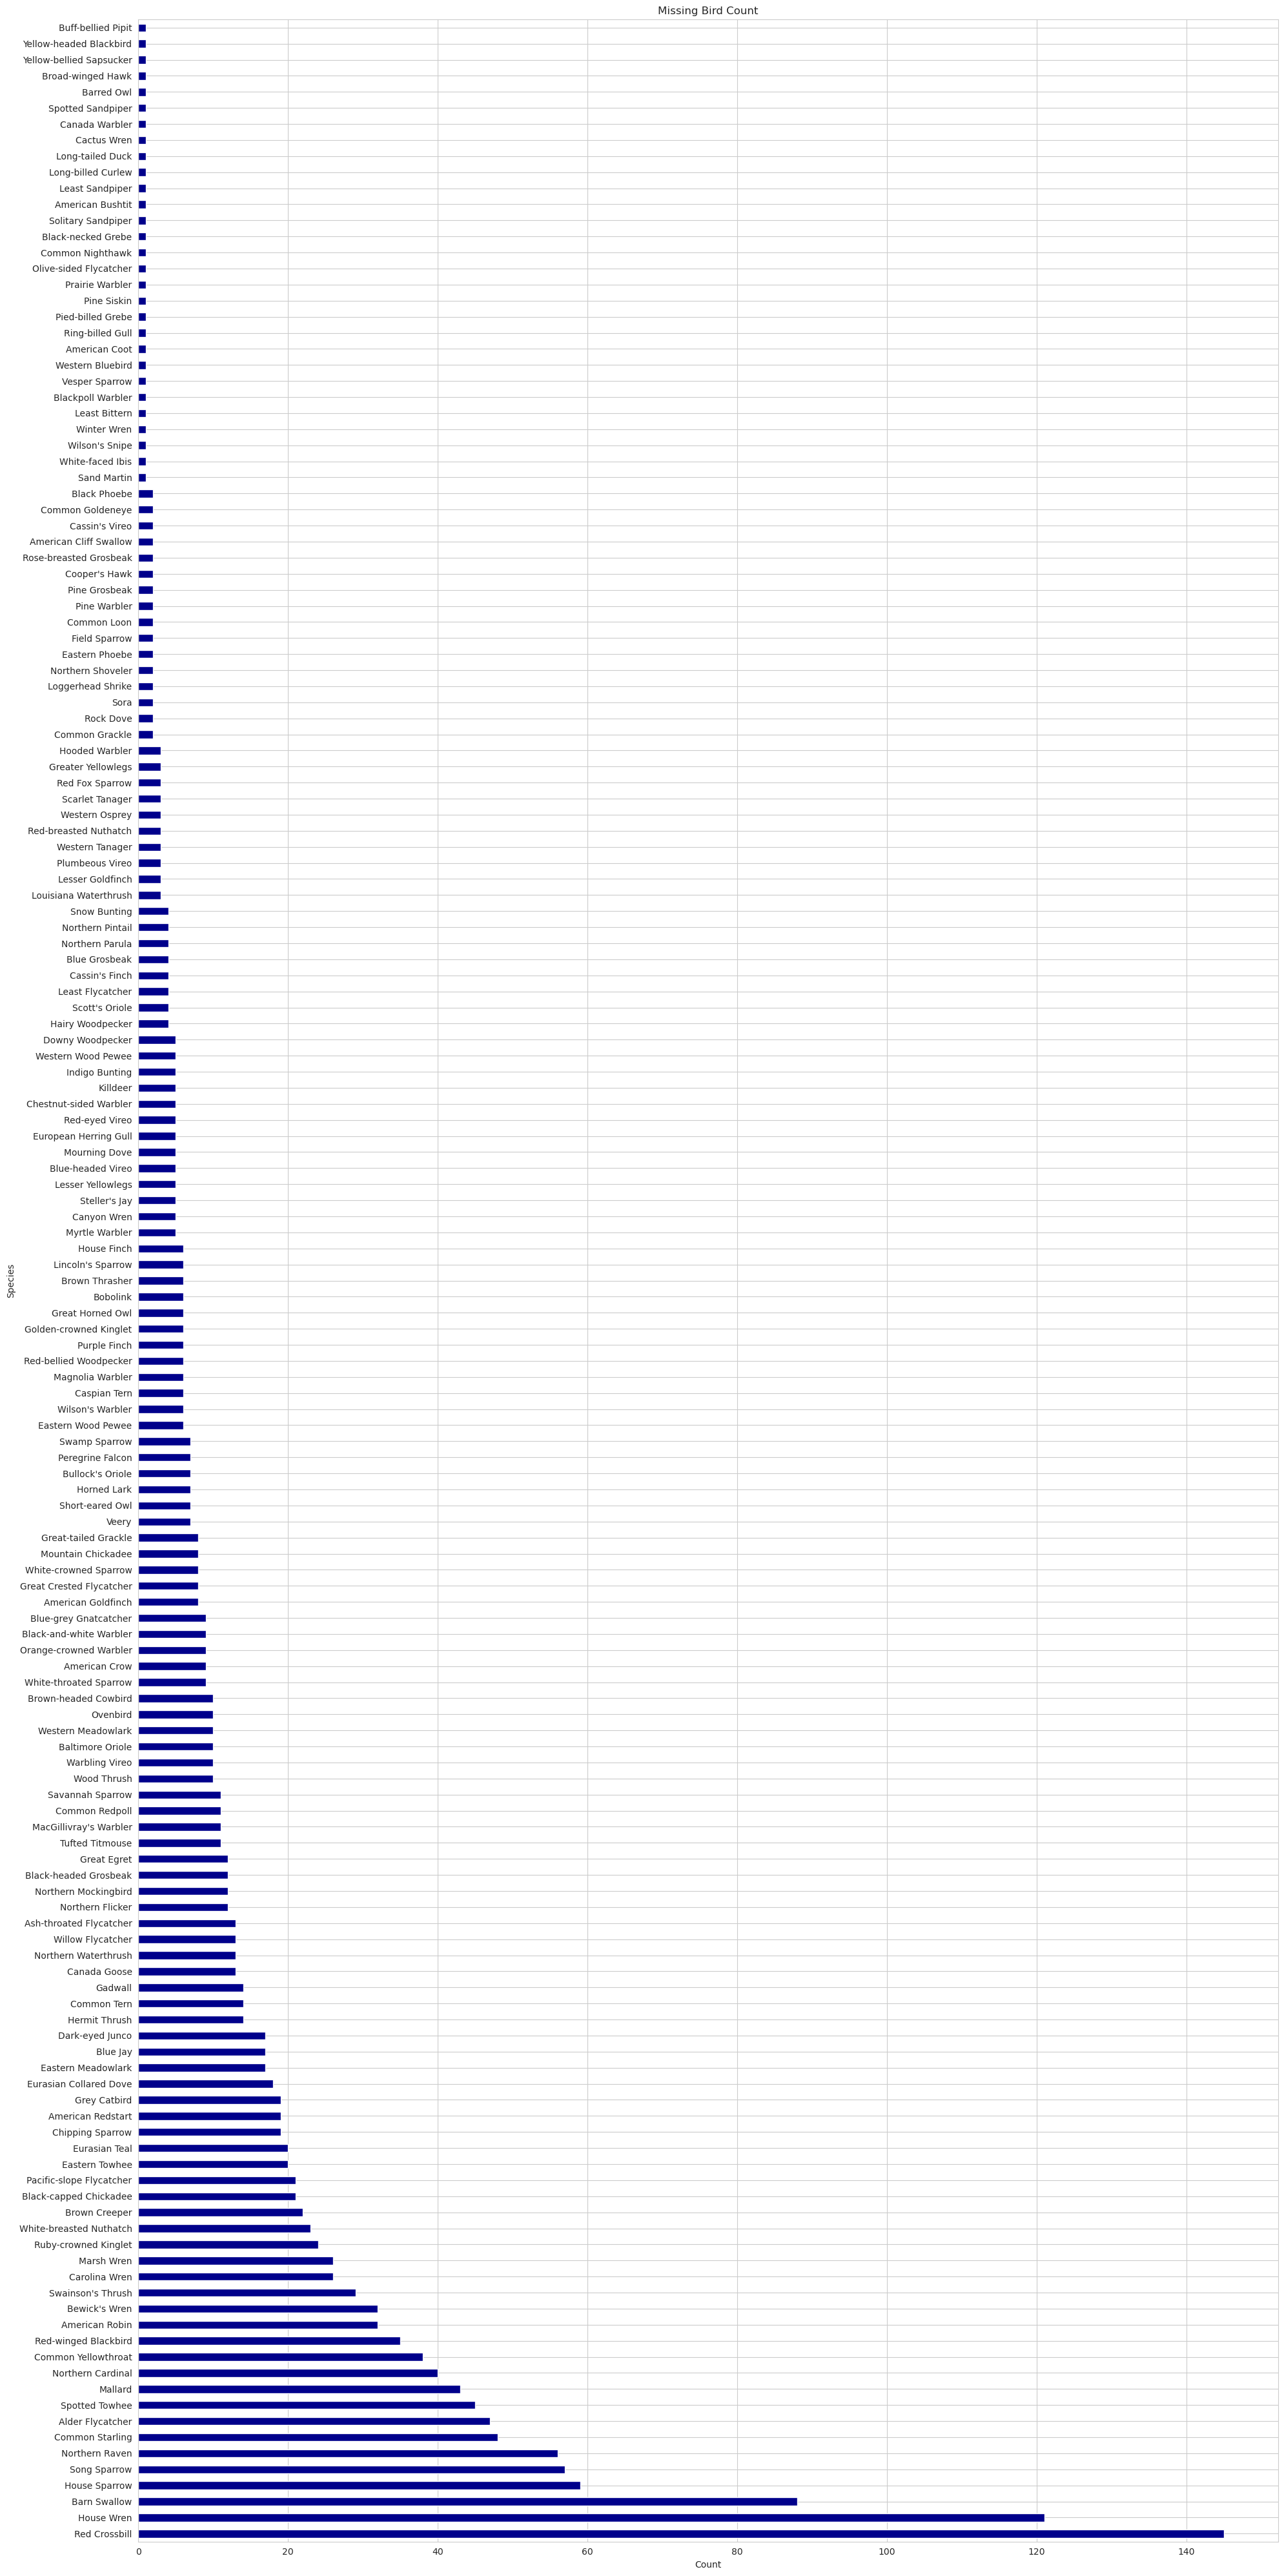

In [37]:
# Visualize this with a horizontal bar plot
plt.figure(figsize=(20, 40))
missing_birds.plot(kind='barh', color='darkblue')
plt.title('Missing Bird Count')
plt.xlabel('Count')
plt.ylabel('Species')
plt.tight_layout()
plt.show()

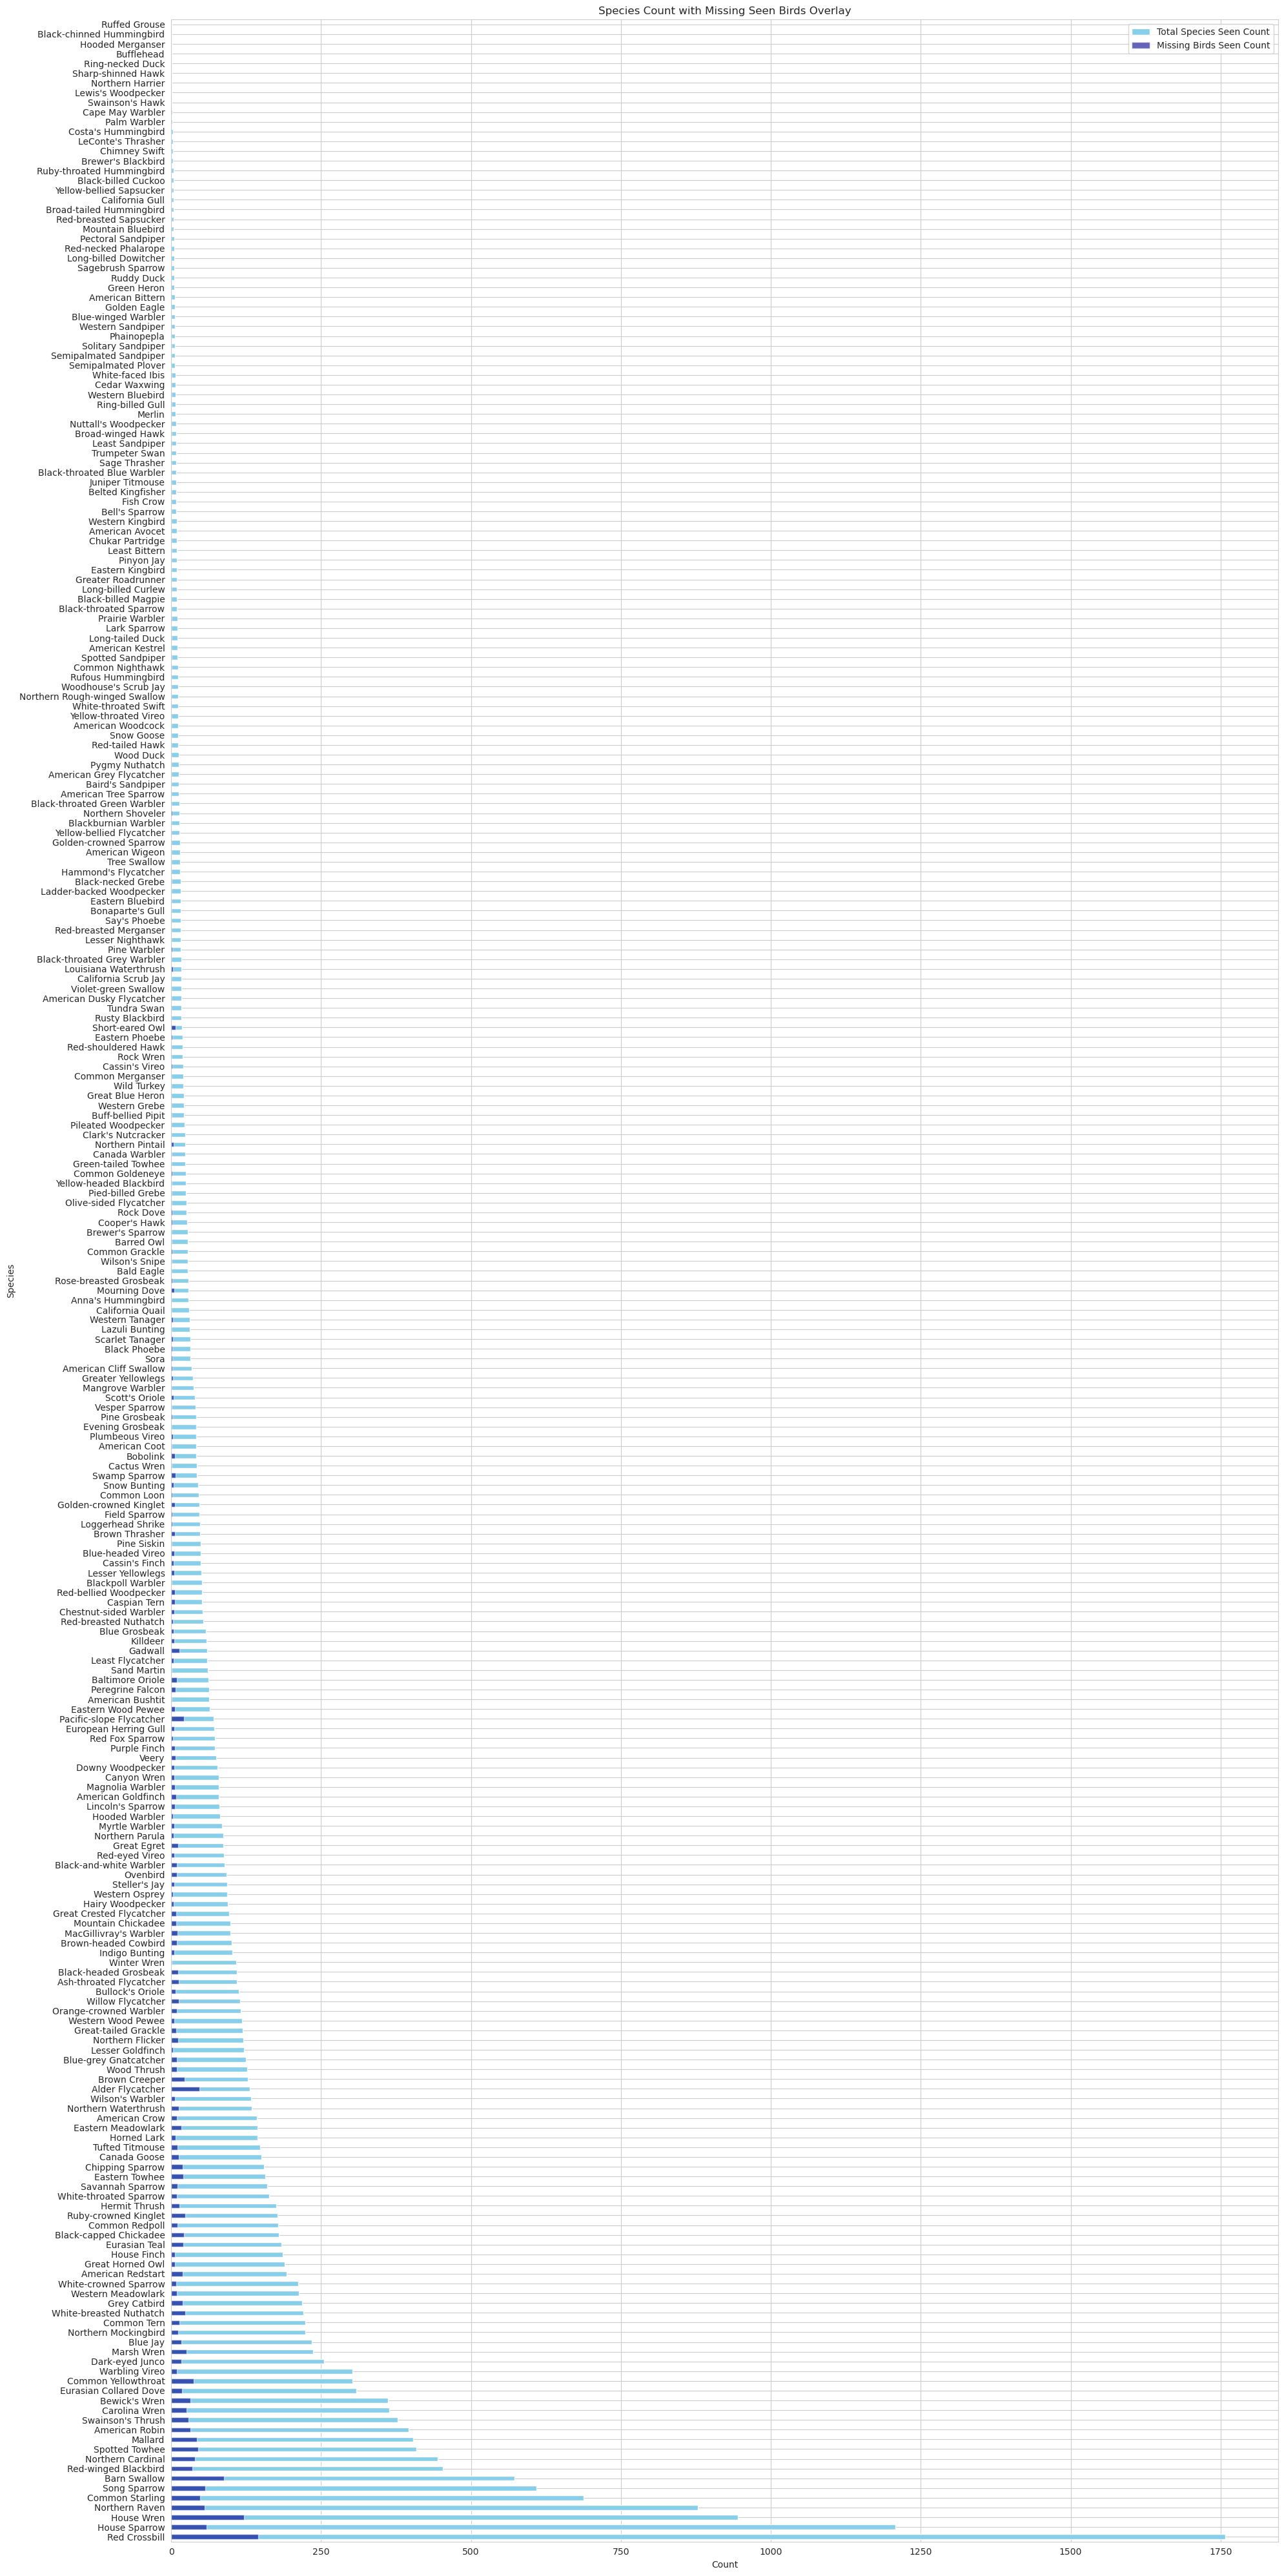

In [38]:
# Plotting the value counts for all species for both "Bird Seen and Bird Not Seen" recordings with a horizontal bar plot
plt.figure(figsize=(20, 40))

# Plotting the total species count
species_counts.plot(kind='barh', color='skyblue', label='Total Species Seen Count')

# Overlaying the missing birds count
missing_birds.reindex(species_counts.index, fill_value=0).plot(kind='barh', color='darkblue', alpha=0.6, label='Missing Birds Seen Count')

plt.title('Species Count with Missing Seen Birds Overlay')
plt.xlabel('Count')
plt.ylabel('Species')
plt.legend()
plt.tight_layout()
plt.show()

Looking at bottom 5%

In [39]:
# see if any values in missing_bird_seen are in the bottom 5% of 'A_Z_df['species']'
# if species in the bottom 5% are missing, we shouldn't remove them and impute somehow (using a distribution of the current yes-no values for bird-seen)

# getting the bottom 5% of species
species_counts = A_Z_df['species'].value_counts() # get the counts of each species
bottom_5_percent = species_counts.quantile(0.05) # get the value at the 5th percentile
bottom_species = species_counts[species_counts <= bottom_5_percent].index # get the species that are in the bottom 5%

In [40]:
bottom_species

Index(['Brewer's Blackbird', 'Chimney Swift', 'LeConte's Thrasher',
       'Costa's Hummingbird', 'Palm Warbler', 'Cape May Warbler',
       'Swainson's Hawk', 'Lewis's Woodpecker', 'Northern Harrier',
       'Sharp-shinned Hawk', 'Ring-necked Duck', 'Bufflehead',
       'Hooded Merganser', 'Black-chinned Hummingbird', 'Ruffed Grouse'],
      dtype='object', name='species')

In [41]:
# there are 15 species that are in the bottom 5% of species in the dataset
print(len(bottom_species))

15


In [42]:
# Total number of bird species in dataset
len(A_Z_df['species'].unique())

259

In [43]:
# number of bird species in the bottom 5% of species within entire dataset
print(len(bottom_species))

15


In [44]:
# check if missing_bird_seen contains any of the bottom species
missing_bottom_species = missing_bird_seen[missing_bird_seen.isin(bottom_species)]

In [45]:
missing_bird_seen

43       Alder Flycatcher
44       Alder Flycatcher
45       Alder Flycatcher
51       Alder Flycatcher
53       Alder Flycatcher
               ...       
23684      Myrtle Warbler
23700      Myrtle Warbler
23736      Myrtle Warbler
23737      Myrtle Warbler
23750      Myrtle Warbler
Name: species, Length: 1877, dtype: object

In [46]:
print(len(missing_bird_seen))

1877


In [47]:
# THERE ARE NO SPECIES FROM THE BOTTOM 5% MISSING FROM BIRD-SEEN
print(len(missing_bottom_species))

0


Now looking at bottom 10%

In [48]:
# getting the bottom 10% of species
species_counts = A_Z_df['species'].value_counts() # get the counts of each species
bottom_10_percent = species_counts.quantile(0.1) # get the value at the 10th percentile
bottom_species_10 = species_counts[species_counts <= bottom_10_percent].index # get the species that are in the bottom 10%

In [49]:
bottom_species_10

Index(['Green Heron', 'Ruddy Duck', 'Sagebrush Sparrow',
       'Long-billed Dowitcher', 'Red-necked Phalarope', 'Pectoral Sandpiper',
       'Mountain Bluebird', 'Red-breasted Sapsucker',
       'Broad-tailed Hummingbird', 'California Gull',
       'Yellow-bellied Sapsucker', 'Black-billed Cuckoo',
       'Ruby-throated Hummingbird', 'Brewer's Blackbird', 'Chimney Swift',
       'LeConte's Thrasher', 'Costa's Hummingbird', 'Palm Warbler',
       'Cape May Warbler', 'Swainson's Hawk', 'Lewis's Woodpecker',
       'Northern Harrier', 'Sharp-shinned Hawk', 'Ring-necked Duck',
       'Bufflehead', 'Hooded Merganser', 'Black-chinned Hummingbird',
       'Ruffed Grouse'],
      dtype='object', name='species')

In [50]:
print(len(bottom_species_10))

28


In [51]:
# check if missing_bird_seen contains any of the bottom species (10%)
missing_bottom_species10 = missing_bird_seen[missing_bird_seen.isin(bottom_species_10)]

In [52]:
# only 1 species from bottom 10%
print(len(missing_bottom_species10))

1


Rationale: There is some justification to remove these missing rows from bird_seen, however... there are 1880 rows that are missing and we want to impute this feature if we can.

Proportion of bottom 5% species with bird_seen being yes and no is 6:19 or 24%

In [53]:
# find the species in bottom_species within A_Z_df2['species'] that have bird_seen == yes
bottom_species_yes = A_Z_df[(A_Z_df['species'].isin(bottom_species)) & (A_Z_df['bird_seen'] == 'yes')]['species']
print(len(bottom_species_yes))

# there are 19 species in the bottom 5% of species that have bird_seen == yes

19


In [54]:
# find the species in bottom_species within A_Z_df2['species'] that have bird_seen == no
bottom_species_no = A_Z_df[(A_Z_df['species'].isin(bottom_species)) & (A_Z_df['bird_seen'] == 'no')]['species']
print(len(bottom_species_no))

# there are 6 species in the bottom 5% of species that have bird_seen == no

6


Proportion of bottom 10% species with bird_seen being yes and no is 15:67 or 18.3%

In [55]:
bottom_species_yes10 = A_Z_df[(A_Z_df['species'].isin(bottom_species_10)) & (A_Z_df['bird_seen'] == 'yes')]['species']
print(len(bottom_species_yes10))

67


In [56]:
bottom_species_no10 = A_Z_df[(A_Z_df['species'].isin(bottom_species_10)) & (A_Z_df['bird_seen'] == 'no')]['species']
print(len(bottom_species_no10))

15


#### Proportion of bird species from the missing values is very similar to the actual proportion/distribution of bird_seen (yes/no) values in the entire dataset is 5672:15776 or 26.4%

In [57]:
# We want to take all missings rows from bird_seen and impute them by randomly assigning 'yes' or 'no' based on the distribution of 'yes' and 'no' values for the species (5672:15776) 26.4% : 73.6%
random.seed(43)

# imputing missing values in bird_seen column based on proportion
for species in A_Z_df['species'].unique():
    species_df = A_Z_df[A_Z_df['species'] == species]
    if species_df['bird_seen'].isnull().any():
        yes_weight = species_df['bird_seen'].eq('yes').mean() if species_df['bird_seen'].notnull().any() else 0.264
        no_weight = 1 - yes_weight
        for index in species_df[species_df['bird_seen'].isnull()].index:
            imputed_value = random.choices(['yes', 'no'], weights=[yes_weight, no_weight])[0]
            A_Z_df.loc[index, 'bird_seen'] = imputed_value

In [58]:
# Checking to see if imputation was successful
print(A_Z_df['bird_seen'].isnull().sum())

0


### Playback-Used: Imputing
- is there a reason why recordings used with play-back should be discounted? (this is more about yes/no)

1. competition dataset
2. playback calls are the same bird, so if anything it's not a different bird which would heavily disrupt the model
3. playback is presumably used by more professional/experienced birders
4. 2% of all recordings used playback
5. if playback is used (yes), do they occur in the audio file? (i.e., is playback used before the beginning of recording? Does it need to be consistently played? Are target birds in audio clips the birds that are chirping softer than the playback?)
6. Even if there is playback used to elicit target bird, it's more so likely that when trying to predict for that target bird, the method used to elicit and record that bird call/song would most likely be playback (i.e., the same for the model).

In [59]:
# how many missing values are there in playback_used?
A_Z_df['playback_used'].isnull().sum()

1730

Checking average rating for both playback_used == 'no' and 'yes'. 
- Hypothesis is that playback_used may have a lower average rating. If so, we can impute missings for playback_used with this justification...however we went online to xeno-canto's forums and found out several things that negate this hypothesis (listed in the Ratings section). Thus, we are choosing a different imputation approach.

In [60]:
# Find the average rating of all recordings where playback_used == Yes
print(A_Z_df[A_Z_df['playback_used'] == 'yes']['rating'].mean())

2.9507042253521125


In [61]:
# Find the average rating of all recordings where playback_used == No
print(A_Z_df[A_Z_df['playback_used'] == 'no']['rating'].mean())

3.2975010669069182


In [62]:
# for all missing rows of playback_used, look at the average rating of all of those rows

# get all missing rows in playback_used
missing_playback = A_Z_df[A_Z_df['playback_used'].isnull()]

# get the average rating of all missing rows
missing_playback['rating'].mean()

print(missing_playback['rating'].mean())

3.0106936416184973


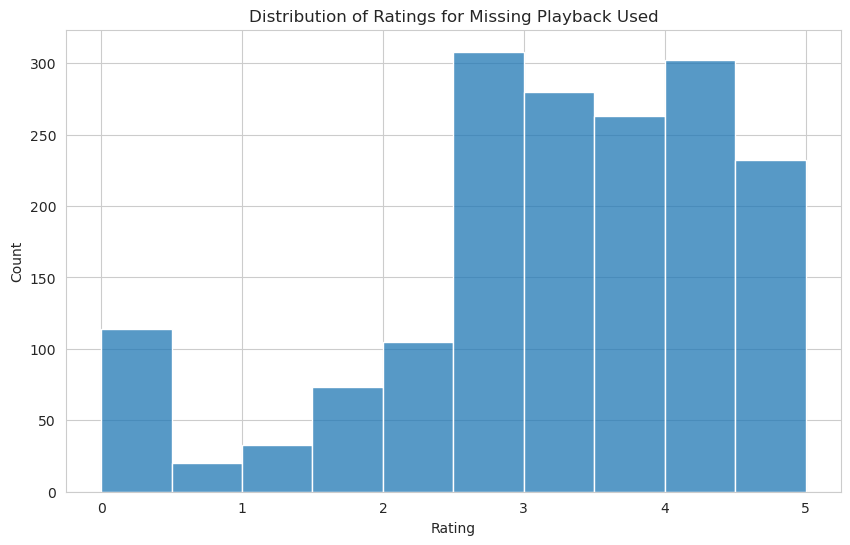

In [63]:
plt.figure(figsize=(10, 6))

sns.histplot(data=missing_playback, x='rating', bins=10)
plt.title('Distribution of Ratings for Missing Playback Used')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

First, we'll look at proportions of playback_used for the bottom 5% again

In [64]:
# find the species in bottom_species within A_Z_df2['species'] that have playback_used == yes
bottom_species_yes_pb = A_Z_df[(A_Z_df['species'].isin(bottom_species)) & (A_Z_df['playback_used'] == 'yes')]['species']
print(len(bottom_species_yes_pb))

# there are 2 species in the bottom 5% of species that have playback_used == yes

2


In [65]:
# find the species in bottom_species within A_Z_df2['species'] that have playback_used == no
bottom_species_no_pb = A_Z_df[(A_Z_df['species'].isin(bottom_species)) & (A_Z_df['playback_used'] == 'no')]['species']
print(len(bottom_species_no_pb))

# there are 21 species in the bottom 5% of species that have playback_used == no

21


Now looking at the bottom 10%

In [66]:
bottom_species_yes_pb_10 = A_Z_df[(A_Z_df['species'].isin(bottom_species_10)) & (A_Z_df['playback_used'] == 'yes')]['species']
print(len(bottom_species_yes_pb_10))

2


In [67]:
bottom_species_no_pb_10 = A_Z_df[(A_Z_df['species'].isin(bottom_species_10)) & (A_Z_df['playback_used'] == 'no')]['species']
print(len(bottom_species_no_pb_10))

77


#### Final Approach:
We will impute based on the average number of playback_used == yes and playback_used == no for each species (i.e., if a species has more playback_used == yes, then we impute 'yes' for the missing values, and vice versa)

In [68]:
avg_counts = A_Z_df.groupby('species')['playback_used'].value_counts(normalize=True).unstack(fill_value=0)
avg_counts = avg_counts.div(avg_counts.sum(axis=1), axis=0)

# Replace 0 with NaN to avoid dividing by zero
avg_counts = avg_counts.replace(0, np.nan)

# Merge the average counts back into the original dataframe
A_Z_df = pd.merge(A_Z_df, avg_counts, on='species', how='left', suffixes=('', '_avg'))

In [69]:
def impute_playback_used(row):
    if pd.isna(row['playback_used']):
        if row['yes'] > row['no']:
            return 'yes'
        else:
            return 'no'
    else:
        return row['playback_used']

In [70]:
A_Z_df['playback_used'] = A_Z_df.apply(impute_playback_used, axis=1)

In [71]:
missings = A_Z_df['playback_used'].isnull().sum()
print(f"Missing values after imputation: {missings}")

Missing values after imputation: 0


In [72]:
A_Z_df['playback_used'].value_counts()

playback_used
no     22819
yes      497
Name: count, dtype: int64

In [73]:
# Dropping the unnecessary columns
A_Z_df = A_Z_df.drop(['yes', 'no'], axis=1)

In [74]:
# check if any rows have missing values now
A_Z_df.isnull().sum()

rating              0
playback_used       0
ebird_code          0
channels            0
date                0
duration            0
filename            0
species             0
title               0
secondary_labels    0
bird_seen           0
sci_name            0
location            0
latitude            0
sampling_rate       0
type                0
elevation           0
bitrate_of_mp3      0
file_type           0
background          0
xc_id               0
url                 0
country             0
author              0
primary_label       0
longitude           0
time                0
recordist           0
license             0
dtype: int64

In [75]:
# no more extra rows
print(f"The shape of the dataframe is :", A_Z_df.shape)
A_Z_df.info()

The shape of the dataframe is : (23316, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23316 entries, 0 to 23315
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rating            23316 non-null  float64
 1   playback_used     23316 non-null  object 
 2   ebird_code        23316 non-null  object 
 3   channels          23316 non-null  object 
 4   date              23316 non-null  object 
 5   duration          23316 non-null  int64  
 6   filename          23316 non-null  object 
 7   species           23316 non-null  object 
 8   title             23316 non-null  object 
 9   secondary_labels  23316 non-null  object 
 10  bird_seen         23316 non-null  object 
 11  sci_name          23316 non-null  object 
 12  location          23316 non-null  object 
 13  latitude          23316 non-null  float64
 14  sampling_rate     23316 non-null  object 
 15  type              23316 non-null  object 
 

### Elevation: Imputing

In [76]:
# function for cleaning and processing messy elevation values
def clean_elevation(elevation):
    if pd.isna(elevation):
        return None
    elevation = str(elevation).lower().strip()
    if 'unknown' in elevation:
        return None

    # Handle ranges of elevation with two numbers and a '-' in between
    if '-' in elevation:
        parts = re.split(r'\s*-\s*', elevation)
        try:
            numbers = [float(re.sub(r'[^\d.-]', '', part)) for part in parts if re.sub(r'[^\d.-]', '', part)]
            if len(numbers) == 2:
                return int(round(sum(numbers) / len(numbers)))
        except ValueError:
            return None

    # Get rid of any non-numeric characters and convert to float
    elevation = re.sub(r'[^\d.-]', '', elevation)
    try:
        elevation = float(elevation)
        return int(round(elevation))
    except ValueError:
        return None

# Apply function to the column 'elevation'
A_Z_df['elevation'] = A_Z_df['elevation'].apply(clean_elevation)

In [77]:
# Check for the missing values
missing_values = A_Z_df['elevation'].isna().sum()
print(f'Missing values in elevation: {missing_values}')

Missing values in elevation: 970


In [78]:
# replace all missing rows with 0
A_Z_df['elevation'] = A_Z_df['elevation'].fillna(0)

In [79]:
# check if all columns in A_Z_df have missing or not
A_Z_df.isnull().sum()

rating              0
playback_used       0
ebird_code          0
channels            0
date                0
duration            0
filename            0
species             0
title               0
secondary_labels    0
bird_seen           0
sci_name            0
location            0
latitude            0
sampling_rate       0
type                0
elevation           0
bitrate_of_mp3      0
file_type           0
background          0
xc_id               0
url                 0
country             0
author              0
primary_label       0
longitude           0
time                0
recordist           0
license             0
dtype: int64

In [80]:
# save out to file
A_Z_df.to_csv('./train_extended_cleaned.csv', index=False)

# Feature Analysis

## Ratings

from updated xeno-canto rating guidelines (https://xeno-canto.org/help/FAQ#rating):

    A: Loud and Clear
    B: Clear, but animal a bit distant, or some interference with other sound sources
    C: Moderately clear, or quite some interference
    D: Faint recording, or much interference
    E: Barely audible

There are several points to be made about the rating scores associated with the dataset. These empirical observations have been made based on both the EDA findings coupled with the evidence found directly on the xeno-canto website. The majority of which empirical evidence was found in posts on the website’s forum section, devoted to discussing key elements of the website, in this case the subforum for rating discussions.

1.    The actual rating system has been updated since our dataset has been created, i.e. the 0 to 5 rating scale with half point intervals (e.g. 0, 0.5, 1 etc.) has been replaced by a simple A – E rating system. Translated, this is essentially turned a 0 -10 scale to a 1-5 scale. It is not clear when exactly this change was made and what the then guidelines were, but sometime between 2020 and 2024.
2.    Overall, the ratings are not actively managed, or not considered a priority by the site administrators. Several posts indicate that the rating system was even less of a priority for the administrators in the past.
3.    Anyone with a xeno-canto account can leave a rating, while non-account holders are only able to visually see the ratings. We can only assume that this was also true when the dataset was made in 2020.
4.    There is no limit for the amount ratings an account holder can make. Account holders can leave ratings for every recording on the site.
5.    There are no clear metrics for a rating. This means, it is not clear if final ratings in the dataset are merely an average rating left by users or a majority of the given rating.
6.    Several posts, including those from administrators confirm that the rating system on a whole is unreliable and not reflective of actual recording quality to the extent that we cannot be assured whether there is any true correlation between ratings and the quality of the recordings. This is further exacerbated by the fact that many recordings appear to have undergone rating sabotage, i.e. users have targeted certain recordists and deliberately changed ratings by giving them lower ratings.


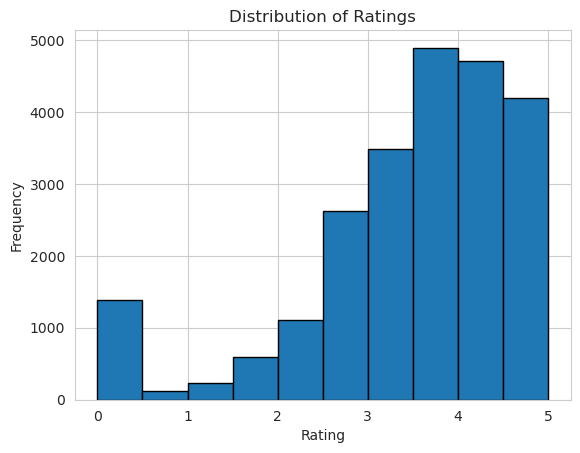

In [81]:
# Plotting the distribution of ratings
ratings = A_Z_df['rating']

plt.hist(ratings, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

In [82]:
A_Z_df['rating'].value_counts()

rating
3.5    4893
4.0    4703
3.0    3490
2.5    2617
4.5    2147
5.0    2044
0.0    1382
2.0    1107
1.5     591
1.0     226
0.5     116
Name: count, dtype: int64

In [83]:
min_rating = A_Z_df['rating'].min()
max_rating = A_Z_df['rating'].max()
avg_rating = A_Z_df['rating'].mean()

print("Minimum Rating:", min_rating)
print("Maximum Rating:", max_rating)
print("Average Rating:", avg_rating)

Minimum Rating: 0.0
Maximum Rating: 5.0
Average Rating: 3.2688282724309485


## Playback Used
- playback is a technique used by birders to elicit bird calls from birds that don't usually come out as often and for other reasons (e.g., mating, and birds calling to protect territory) (https://www.sibleyguides.com/2011/04/the-proper-use-of-playback-in-birding/)

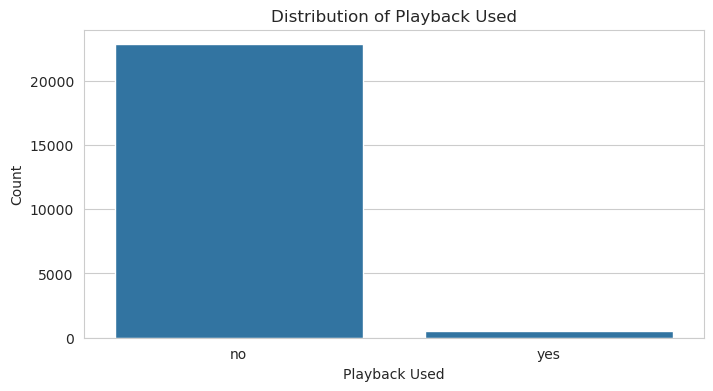

In [84]:
plt.figure(figsize=(8, 4))
sns.countplot(data=A_Z_df, x='playback_used')
plt.title('Distribution of Playback Used')
plt.xlabel('Playback Used')
plt.ylabel('Count')
plt.show()

In [85]:
A_Z_df['playback_used'].value_counts()

playback_used
no     22819
yes      497
Name: count, dtype: int64

## Ebird_code
- A shortened form of the species name, serving as a form of a unique ID. 
- We don't need to inspect this further, it's irrelevant for our task.

## Channels
- Stereo or Mono per recording

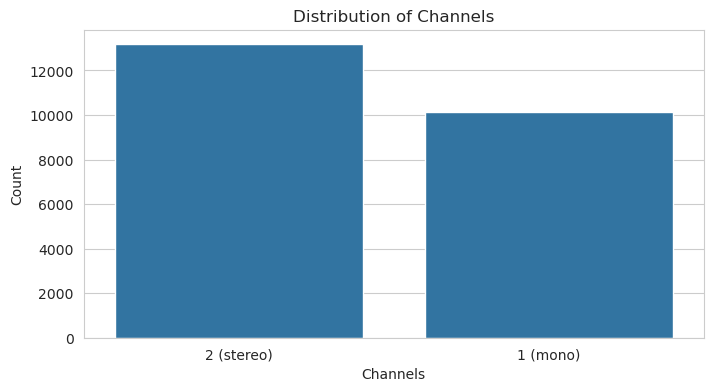

In [86]:
plt.figure(figsize=(8, 4))
sns.countplot(data=A_Z_df, x='channels')
plt.title('Distribution of Channels')
plt.xlabel('Channels')
plt.ylabel('Count')
plt.show()

In [87]:
channel_counts = A_Z_df['channels'].value_counts()
print(channel_counts)

channels
2 (stereo)    13172
1 (mono)      10144
Name: count, dtype: int64


## Date of recording

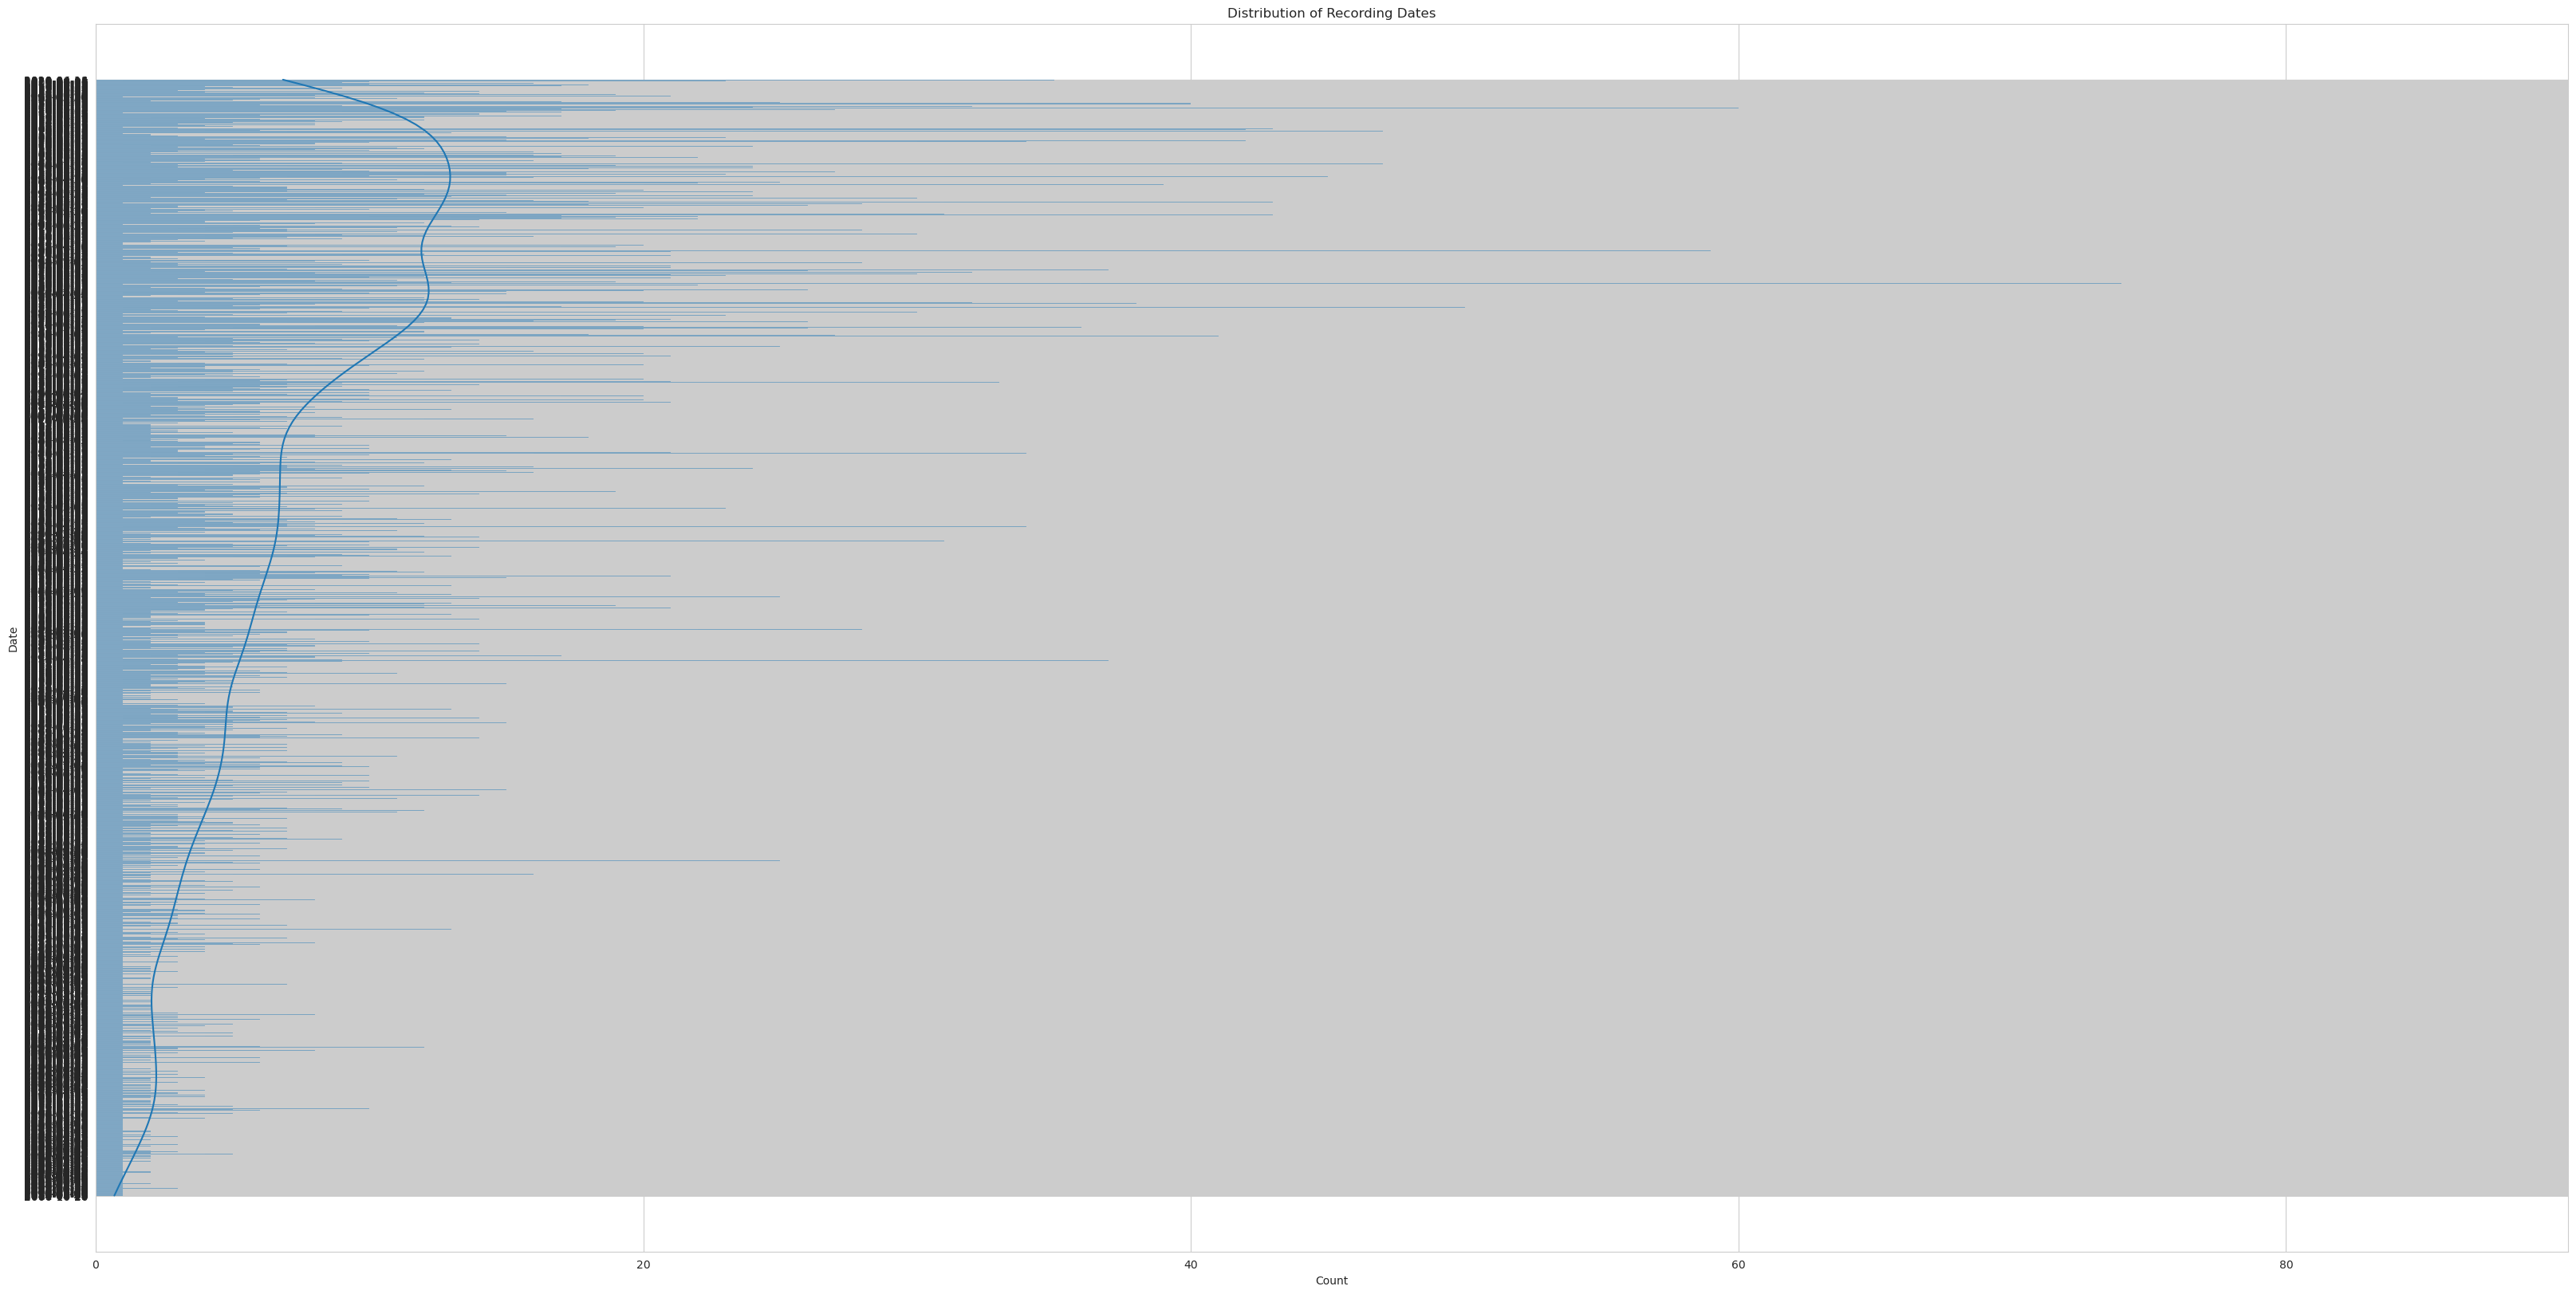

In [88]:
plt.figure(figsize=(40, 20))

sns.histplot(y=A_Z_df['date'], kde=True)
plt.title('Distribution of Recording Dates')
plt.ylabel('Date')
plt.xlabel('Count')
plt.yticks(rotation=0)
plt.show()

In [89]:
A_Z_df['date'].value_counts()

date
2020-07-19    86
2020-05-21    74
2020-04-25    68
2018-06-08    66
2020-04-19    60
              ..
2012-09-16     1
2011-10-03     1
1997-06-09     1
2009-11-29     1
2005-03-23     1
Name: count, Length: 3651, dtype: int64

In [90]:
earliest_date = A_Z_df['date'].min()
latest_date = A_Z_df['date'].max()

print(f"Earliest Date: {earliest_date}")
print(f"Latest Date: {latest_date}")

Earliest Date: 1967-06-19
Latest Date: 2020-09-13


In [91]:
# average date
A_Z_df['date'] = pd.to_datetime(A_Z_df['date'])

average_date = A_Z_df['date'].mean()

print("Average date:", average_date)

Average date: 2016-06-19 13:24:10.746268672


## Filename

This just serves as a key. Inconsequential in our work.

## Species

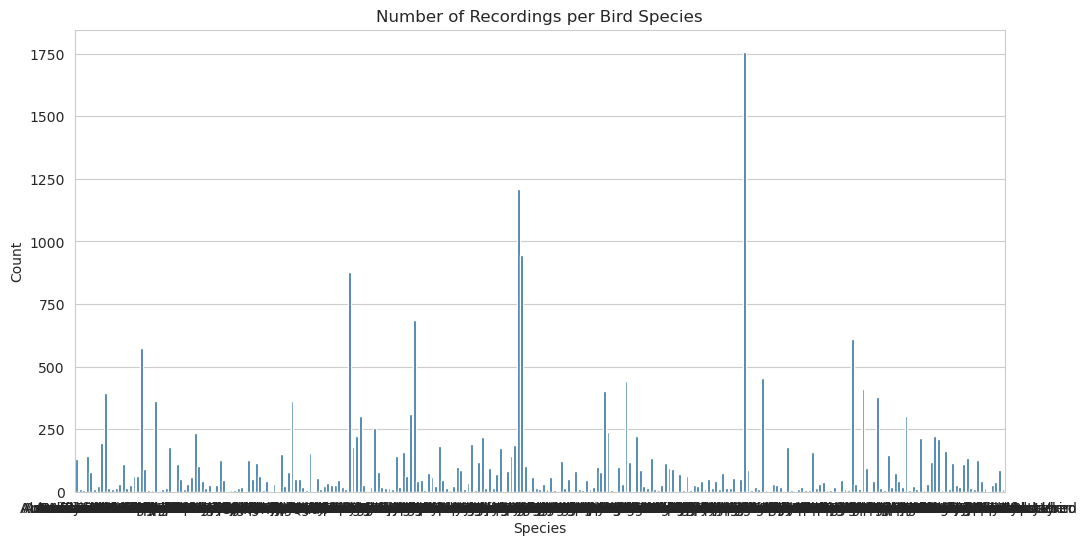

In [92]:
plt.figure(figsize=(12, 6))
sns.countplot(data=A_Z_df, x='species')
plt.title('Number of Recordings per Bird Species')
plt.xlabel('Species')
plt.ylabel('Count')
plt.show()

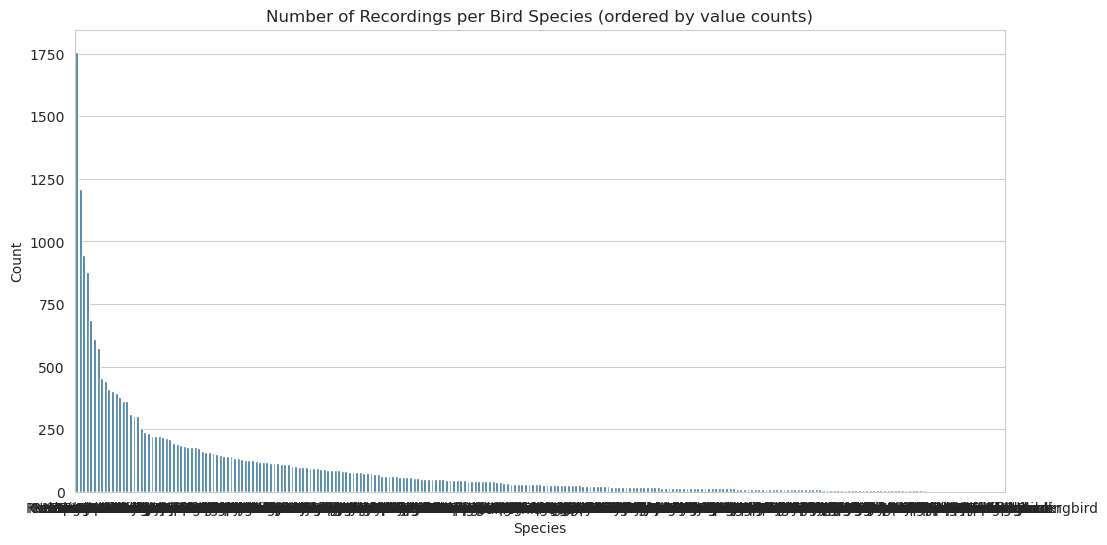

In [93]:
plt.figure(figsize=(12, 6))
sns.countplot(data=A_Z_df, x='species', order=A_Z_df['species'].value_counts().index)
plt.title('Number of Recordings per Bird Species (ordered by value counts)')
plt.xlabel('Species')
plt.ylabel('Count')
plt.show()

In [94]:
A_Z_df['species'].value_counts()

species
Red Crossbill                1758
House Sparrow                1208
House Wren                    945
Northern Raven                878
Common Starling               688
                             ... 
Ring-necked Duck                1
Bufflehead                      1
Hooded Merganser                1
Black-chinned Hummingbird       1
Ruffed Grouse                   1
Name: count, Length: 259, dtype: int64

In [95]:
A_Z_df['species'].nunique()

259

## Title

Another feature of the data that we can safely ignore. This serves as another unique ID.

## Secondary Labels

Secondary labels serve as a combination of common name and scientific name for background species present in the sound clip. Since we are covering background species elsewhere, it is unnecessary to retread.

## Bird-seen
- Hypothesis: if a bird is physically sighted > it's close (within sight) > it's close enough to be heard
- We need to keep in mind of what date/technology was used for recordings wrt bird-seen

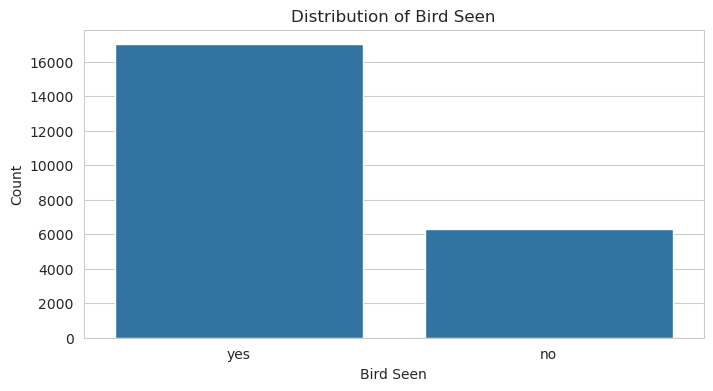

In [96]:
plt.figure(figsize=(8, 4))
sns.countplot(data=A_Z_df, x='bird_seen')
plt.title('Distribution of Bird Seen')
plt.xlabel('Bird Seen')
plt.ylabel('Count')
plt.show()

In [97]:
print(A_Z_df['bird_seen'].value_counts())

bird_seen
yes    17004
no      6312
Name: count, dtype: int64


## Sci-name

- Scientific name of the primary species of the recording
- Same as primary label

## Location
- The local town, park, or proper place at which the data is recorded. Varying degrees of geographical information are given.

In [98]:
location_counts = A_Z_df['location'].value_counts()
num_unique_locations = len(location_counts)

print("Number of unique locations:", num_unique_locations)
print("Location counts:\n")
print(location_counts)

Number of unique locations: 7237
Location counts:

location
Toky, Pidvolochys'kyi district, Ternopil's'ka oblast        163
Hendrix Habitat - Fairview, Williamson County, Tennessee    144
Topolobampo, Ahome, Sinaloa                                 140
Tama (near  Burlington), Des Moines, Iowa                   130
Yard, Croton, New York                                      130
                                                           ... 
Momas, Pyrénées-Atlantiques, Aquitaine                        1
Manabí: La Segua marsh (Chone lakes)                          1
Lagune de Somone, Thiès                                       1
Tucan Country Club & Resort                                   1
Conchas, Conchas, São Paulo                                   1
Name: count, Length: 7237, dtype: int64


## Sampling Rate
- The number of samples of audio recorded per second measured in Hertz (Hz). It determines the frequency range and the quality of the audio recording, where higher sampling rates translate to higher resolution fidelity and capturing more details of the sound (by capturing more data)

In [99]:
sampling_rate_counts = A_Z_df['sampling_rate'].value_counts()
num_unique_sampling_rates = len(sampling_rate_counts)
print(sampling_rate_counts)
print("\nNumber of unique sampling rates:", num_unique_sampling_rates)
print("Sampling rate counts:")


most_common_sampling_rate = sampling_rate_counts.idxmax()
percentage_of_rows = (sampling_rate_counts[most_common_sampling_rate] / len(A_Z_df)) * 100

print("\nMost common sampling rate:", most_common_sampling_rate)
print("Percentage of rows with that sampling rate:", percentage_of_rows)

sampling_rate
44100 (Hz)    14459
48000 (Hz)     8332
22050 (Hz)      334
32000 (Hz)       70
16000 (Hz)       60
24000 (Hz)       47
11025 (Hz)        9
8000 (Hz)         3
12000 (Hz)        2
Name: count, dtype: int64

Number of unique sampling rates: 9
Sampling rate counts:

Most common sampling rate: 44100 (Hz)
Percentage of rows with that sampling rate: 62.01320981300395


In [100]:
# cleaning and processing messy sampling rate values
def clean_sampling_rate(sampling_rate):
    if pd.isna(sampling_rate):
        return None
    sampling_rate = str(sampling_rate).lower().strip()
    if 'unknown' in sampling_rate:
        return None

    # getting rid of any non-numeric characters and convert to integer
    sampling_rate = re.sub(r'[^\d]', '', sampling_rate)
    try:
        sampling_rate = int(sampling_rate)
        return sampling_rate
    except ValueError:
        return None

In [101]:
# applying function for sample rate
A_Z_df['sampling_rate_cleaned'] = A_Z_df['sampling_rate'].apply(clean_sampling_rate)

In [102]:
# mode, min, and max
mode_sampling_rate = A_Z_df['sampling_rate_cleaned'].mode()[0]
min_sampling_rate = A_Z_df['sampling_rate_cleaned'].min()
max_sampling_rate = A_Z_df['sampling_rate_cleaned'].max()

print(f'Mode sampling rate: {mode_sampling_rate}')
print(f'Min sampling rate: {min_sampling_rate}')
print(f'Max sampling rate: {max_sampling_rate}')

Mode sampling rate: 44100
Min sampling rate: 8000
Max sampling rate: 48000


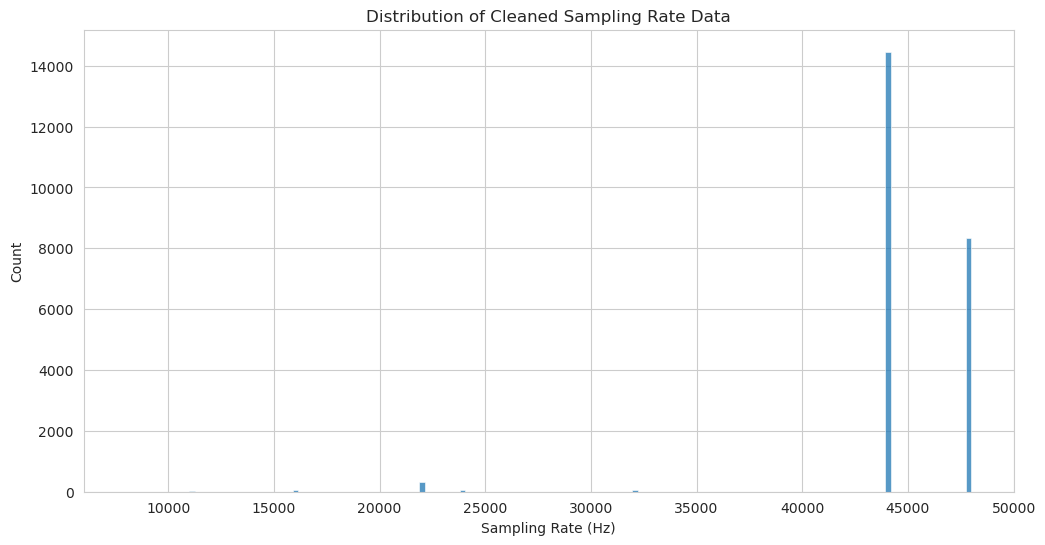

In [103]:
# Plot the distribution of the cleaned sampling rate data
plt.figure(figsize=(12, 6))
sns.histplot(A_Z_df['sampling_rate_cleaned'])
plt.title('Distribution of Cleaned Sampling Rate Data')
plt.xlabel('Sampling Rate (Hz)')
plt.ylabel('Count')
plt.show()

## Type
- What type of sound was recorded, descriptive, recordings could contain labelling of sex

In [104]:
type_counts = A_Z_df['type'].value_counts()
num_type_counts = len(type_counts)

print("Number of unique types:", num_type_counts)
print("Type counts:")
print(type_counts)

Number of unique types: 1521
Type counts:
type
song                                                                                6175
call                                                                                5491
flight call                                                                         1435
call, song                                                                          1205
male, song                                                                           718
                                                                                    ... 
call, chips                                                                            1
"wreep-type" "wit"and rolling "creet" calls, call, song, then song given by male       1
"creet", call, song, trills                                                            1
adult, nocturnal flight call, sex uncertain, song                                      1
adult, male, winnowing                                         

## Elevation
- The elevation at which the recording was made. The data points in the elevation column contained several anomalies in terms of types of entry that needed to be cleaned for proper use. Refer to the notebook for visuals and more specifics. Outliers need to be taken under the microscope here as the min. e.g. does not appear correct as the recording was done in Texas (not -3670 m. below sea level) and the max 7760(m) in Utah, which is not the case.

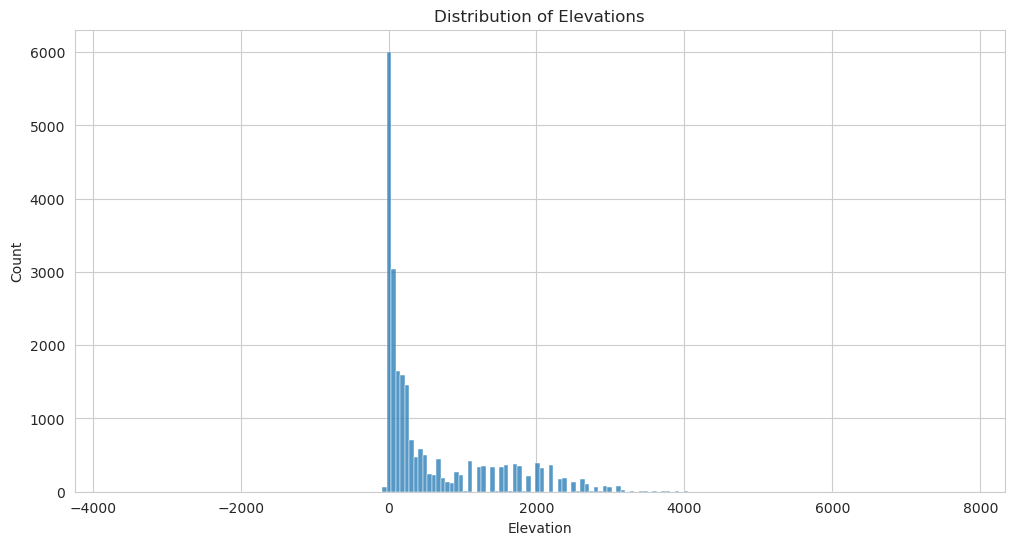

In [105]:
# Plot results
plt.figure(figsize=(12, 6))
sns.histplot(A_Z_df['elevation'])
plt.title('Distribution of Elevations')
plt.xlabel('Elevation')
plt.ylabel('Count')
plt.show()

In [106]:
# max min and mode values
max_elevation = A_Z_df['elevation'].max()
min_elevation = A_Z_df['elevation'].min()
mean_elevation = A_Z_df['elevation'].mode()[0]

print(f'Max elevation: {max_elevation}')
print(f'Min elevation: {min_elevation}')
print(f'Most common elevation: {mean_elevation}')

Max elevation: 7760.0
Min elevation: -3670.0
Most common elevation: 0.0


In [107]:
elevation_stats = A_Z_df['elevation'].describe()
print(f'Descriptive statistics for elevation:\n{elevation_stats}')

Descriptive statistics for elevation:
count    23316.000000
mean       576.977783
std        784.450028
min      -3670.000000
25%         30.000000
50%        200.000000
75%        900.000000
max       7760.000000
Name: elevation, dtype: float64


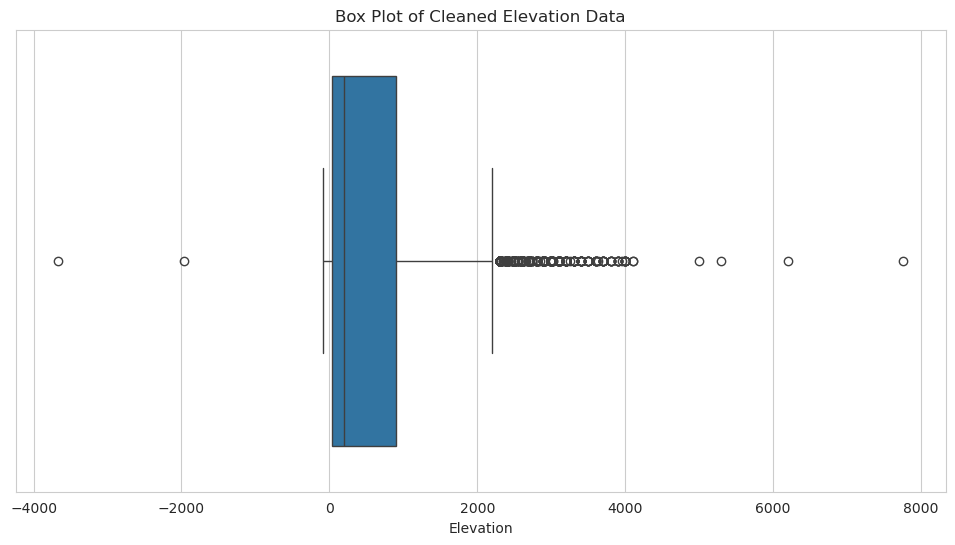

In [108]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=A_Z_df['elevation'])
plt.title('Box Plot of Cleaned Elevation Data')
plt.xlabel('Elevation')
plt.show()

## Bitrate
- The bitrate at which the MP3 file is encoded, provided in kbps (kilobits per second)
- Decided to bin bitrates with low, medium, and high

In [109]:
A_Z_df['bitrate_of_mp3'].value_counts()

bitrate_of_mp3
128000 (bps)    8066
320000 (bps)    5665
192000 (bps)    2428
256000 (bps)     568
96000 (bps)      508
                ... 
112308 (bps)       1
89475 (bps)        1
151592 (bps)       1
152102 (bps)       1
275826 (bps)       1
Name: count, Length: 4202, dtype: int64

In [110]:
# removing (bps)
A_Z_df['bitrate_of_mp3'] = A_Z_df['bitrate_of_mp3'].str.replace(' (bps)', '')

In [111]:
# converting cleaned strings into integers
A_Z_df['bitrate_of_mp3'] = A_Z_df['bitrate_of_mp3'].astype(int)

In [112]:
# Binning the bitrates into 'low', 'medium', and 'high'
def bin_bitrate(bitrate):
    if bitrate <= 128000:
        return 'low'
    elif 128000 < bitrate <= 256000:
        return 'medium'
    else:
        return 'high'

A_Z_df['bitrate_bin'] = A_Z_df['bitrate_of_mp3'].apply(bin_bitrate)

<Axes: xlabel='bitrate_of_mp3', ylabel='Count'>

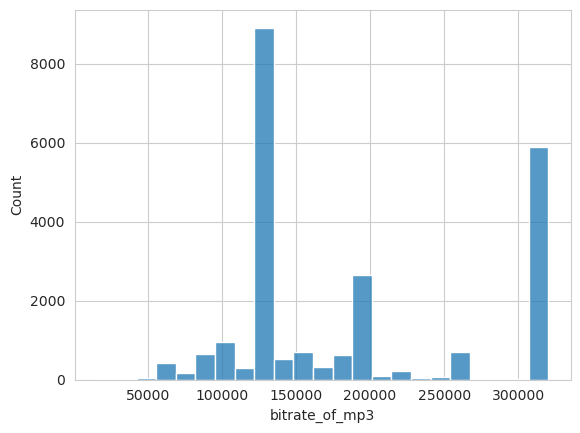

In [113]:
sns.histplot(A_Z_df['bitrate_of_mp3'])

<Axes: xlabel='bitrate_bin', ylabel='Count'>

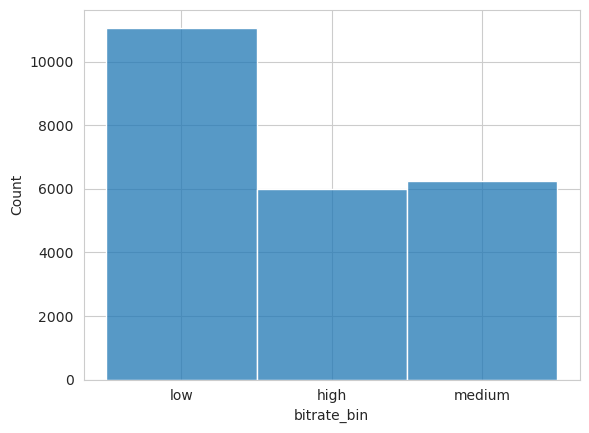

In [114]:
sns.histplot(A_Z_df['bitrate_bin'])

In [115]:
# min, max, average bitrates:
min_bitrate = A_Z_df['bitrate_of_mp3'].min()
max_bitrate = A_Z_df['bitrate_of_mp3'].max()
mean_bitrate = A_Z_df['bitrate_of_mp3'].mode()[0]
print(f"Minimum bitrate: {min_bitrate} kbps")
print(f"Maximum bitrate: {max_bitrate} kbps")
print(f"Most common bitrate: {mean_bitrate} kbps")

Minimum bitrate: 16000 kbps
Maximum bitrate: 320202 kbps
Most common bitrate: 128000 kbps


## File Type

All files are .mp3 files. We can safely ignore this column.

## Background species

- A list of species found in addition to the target species in the background of the audio clip.

In [116]:
A_Z_df['background'].value_counts()

background
None                                                                                                                     12417
Red-winged Blackbird (Agelaius phoeniceus)                                                                                 147
American Robin (Turdus migratorius)                                                                                        123
House Sparrow (Passer domesticus)                                                                                          120
Song Sparrow (Melospiza melodia)                                                                                           104
                                                                                                                         ...  
Winter Wren (Troglodytes hiemalis); Northern Waterthrush (Parkesia noveboracensis); Red Crossbill (Loxia curvirostra)        1
House Sparrow (Passer domesticus); European Starling (Sturnus vulgaris); Great Tit (Parus major)    

In [117]:
def count_species(row):
    if pd.isna(row):  # check if the cell is NaN
        return 0
    else:
        species = row.split(';')  # splitting the string by semicolon
        return len(species)

A_Z_df['num_species'] = A_Z_df['background'].apply(count_species) # applying function to the 'background' column
average_species = A_Z_df['num_species'].mean()
print(f"The average number of background species is {average_species}")

The average number of background species is 1.639475038600103


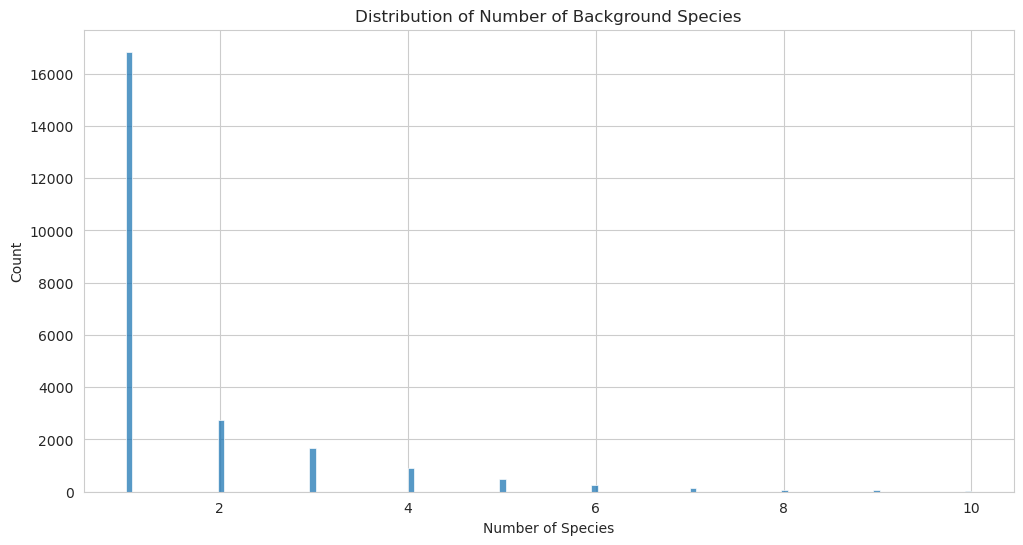

In [118]:
plt.figure(figsize=(12, 6))
sns.histplot(A_Z_df['num_species'][A_Z_df['num_species'] < 11]) # there seems to be at max, 9 species
plt.title('Distribution of Number of Background Species')
plt.xlabel('Number of Species')
plt.ylabel('Count')
plt.show()

## XC_ID

This serves as a unique ID in Xeno-Canto

## URL

This is another unique value, and unimportant for our purposes.

## Country
- The country where the recording is located

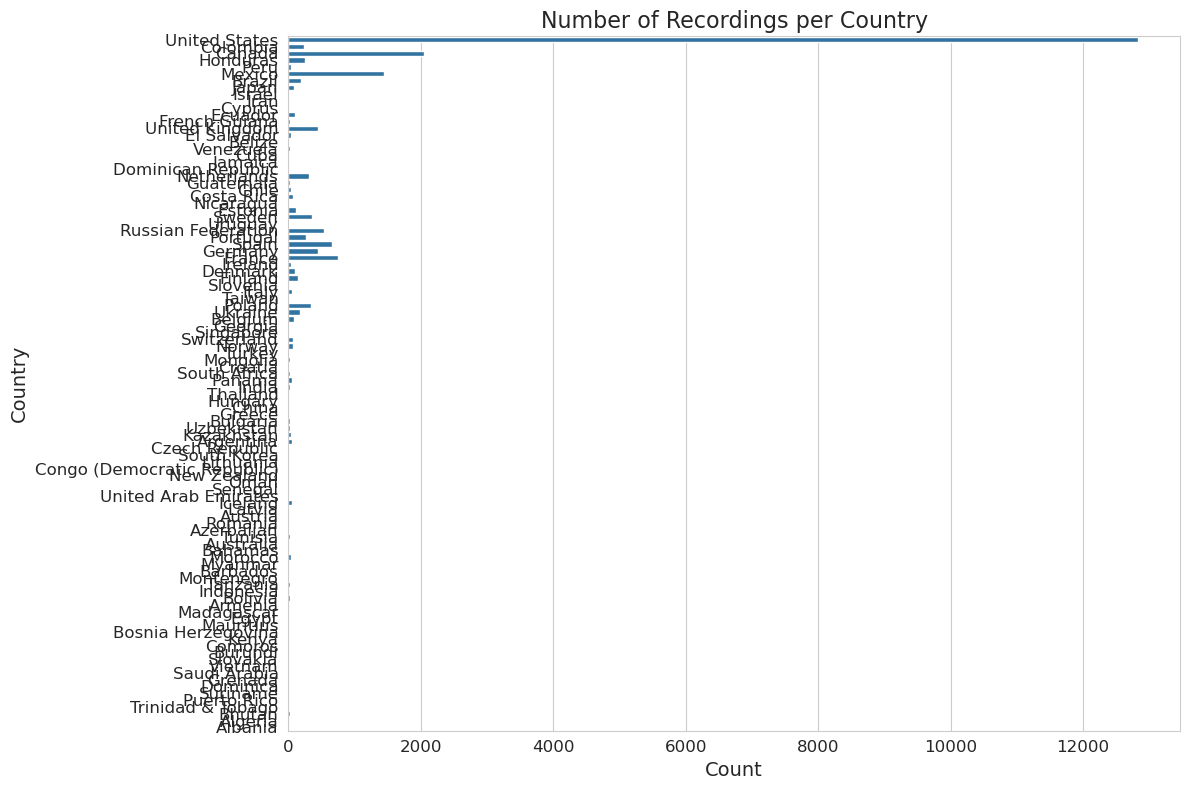

In [119]:
# country
plt.figure(figsize=(12, 8))
sns.countplot(data=A_Z_df, y='country')
plt.title('Number of Recordings per Country', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [120]:
A_Z_df['country'].value_counts()

country
United States    12821
Canada            2048
Mexico            1451
France             753
Spain              658
                 ...  
Barbados             1
Armenia              1
Comoros              1
Burundi              1
Albania              1
Name: count, Length: 102, dtype: int64

## Author

- The name of the author of the audio clip, the recordist in Xeno-Canto terminology

In [121]:
A_Z_df['author'].value_counts()

author
Richard E. Webster    1652
Paul Marvin            930
Thomas Magarian        905
Bobby Wilcox           682
Manuel Grosselet       565
                      ... 
Robin Sommerfeld         1
Leszek Matacz            1
Mario                    1
Michele Peron            1
François Grimal          1
Name: count, Length: 1469, dtype: int64

In [122]:
average_recordings_per_author = A_Z_df['author'].value_counts().mean()
print(f"The average number of recordings per author is {average_recordings_per_author}")

The average number of recordings per author is 15.872021783526208


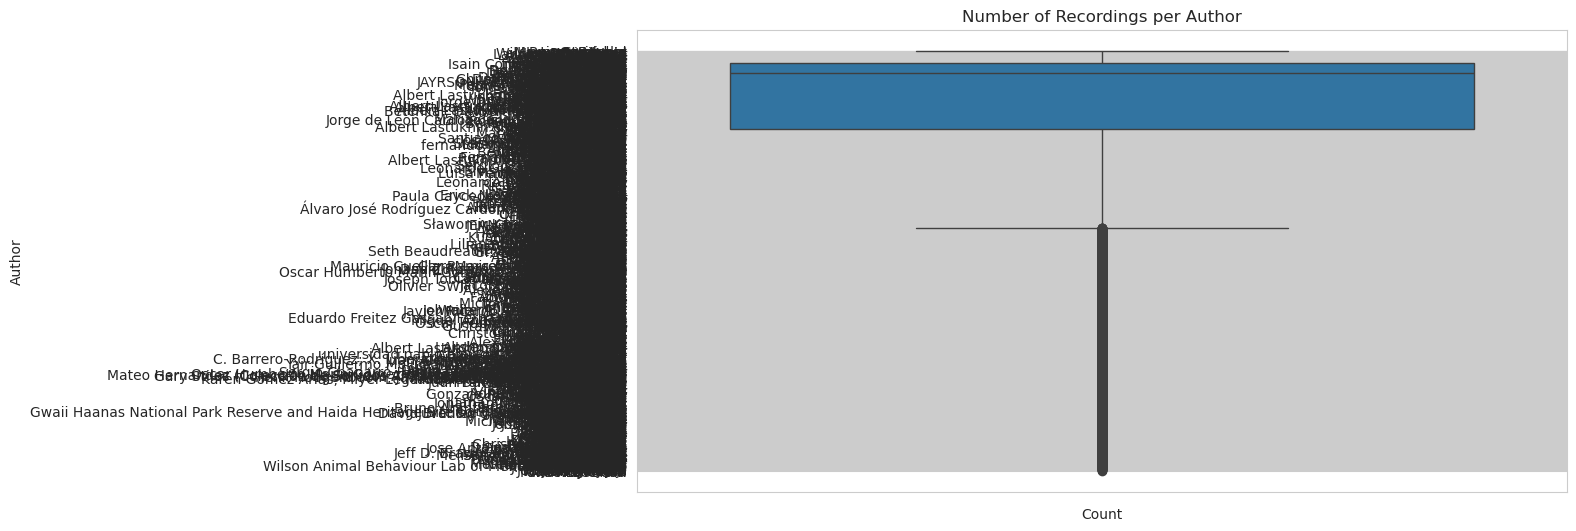

In [123]:
# create horizontal boxplot of authors
plt.figure(figsize=(12, 6))
sns.boxplot(y=A_Z_df['author'])
plt.title('Number of Recordings per Author')
plt.ylabel('Author')
plt.xlabel('Count')
plt.show()

## Primary Label

- The primary species represented in the recording 

## Time (of day)

- Time and Date are found in our dataset. The vast majority are found in Date/Time. While not as easy, we feel as though date/time provides too much to convert to categorical. We are setting all data to Date/Time numerical by finding average times per am/pm, and then setting all AM or PM values to the average.

In [124]:
A_Z_df['time'].value_counts()

time
?           1191
08:00       1047
09:00        969
07:00        890
10:00        824
            ... 
15:56:06       1
13:01:21       1
17:05:20       1
16:08:34       1
11:57:11       1
Name: count, Length: 1862, dtype: int64

In [125]:
def clean_time(time_str):
    time_str = time_str.strip().lower()

    # Remove invalid characters or strings
    if time_str in ['?', '.', '?:?', 'x', 'xx:xx', 'am', 'pm']:
        return None

    # Handle leading zeros and over 24-hour format
    time_str = re.sub(r'^0+(\d)', r'\1', time_str)  # Remove leading zeros
    if re.match(r'^24:([0-5][0-9])(:[0-5][0-9])?$', time_str):
        time_str = re.sub(r'^24:', '00:', time_str)  # Convert 24:xx to 00:xx

    # Convert 12-hour format to 24-hour format
    if 'am' in time_str or 'pm' in time_str:
        try:
            dt_obj = parser.parse(time_str)
            return dt_obj.strftime('%H:%M:%S')
        except ValueError:
            return None

    # Handle standard 24-hour format
    try:
        dt_obj = parser.parse(time_str)
        return dt_obj.strftime('%H:%M:%S')
    except ValueError:
        return None

In [126]:
A_Z_df['time'] = A_Z_df['time'].apply(clean_time)

In [127]:
# look for number of missing values in 'time'
missing_time = A_Z_df['time'].isnull().sum()
print(f"The number of missing values in 'time' is {missing_time}")

The number of missing values in 'time' is 1240


look for the average time that recordings that have missing time values based on bird species and impute the recordings with the average time based on their species

In [128]:
# Convert cleaned time to datetime objects
A_Z_df['time_as_dt'] = pd.to_datetime(A_Z_df['time'], format='%H:%M:%S', errors='coerce')

# Calculate the average time for each species
species_avg_time = A_Z_df.groupby('species')['time_as_dt'].mean()

In [129]:
# Function to convert average time back to string format
def average_time_to_str(time_obj):
    if pd.isna(time_obj):
        return None
    return time_obj.strftime('%H:%M:%S')

In [130]:
species_avg_time = species_avg_time.apply(average_time_to_str)

In [131]:
# Impute missing values with the average time for the corresponding species
def impute_time(row):
    if pd.isna(row['time_as_dt']):
        return species_avg_time.get(row['species'], None)
    return row['time']

In [132]:
A_Z_df['time'] = A_Z_df.apply(impute_time, axis=1)

In [133]:
A_Z_df['time'].isnull().sum()

0

In [134]:
def round_seconds_to_minutes(time_str):
    if pd.isna(time_str):
        return None
    dt_obj = parser.parse(time_str)
    # Round seconds
    if dt_obj.second >= 30:
        dt_obj += pd.Timedelta(minutes=1)
    return dt_obj.strftime('%H:%M')

In [135]:
A_Z_df['time'] = A_Z_df['time'].apply(round_seconds_to_minutes)

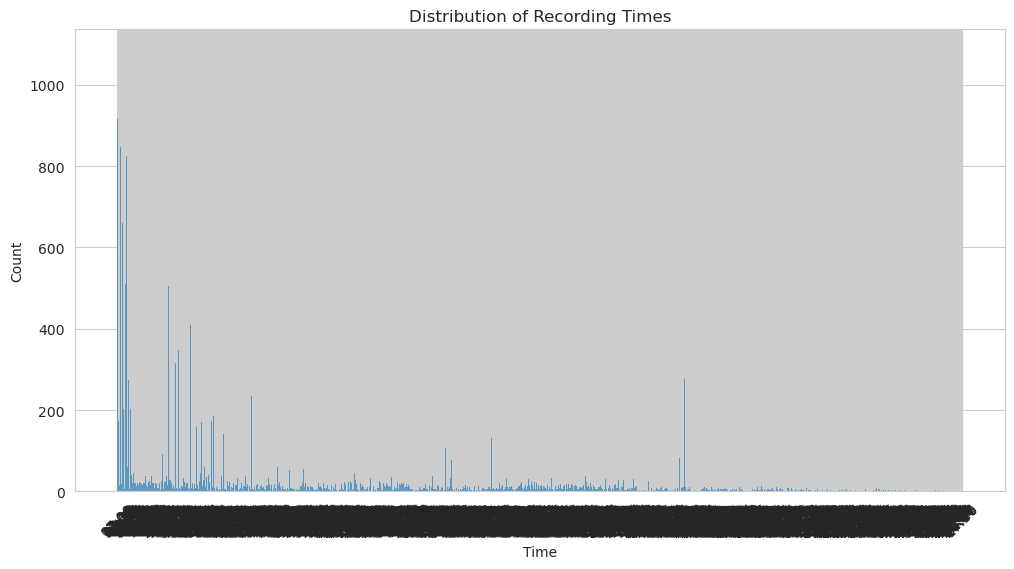

In [136]:
# plot distribution of recording times from "time" column (in 24-hour format)

plt.figure(figsize=(12, 6))
sns.histplot(A_Z_df['time'])
plt.title('Distribution of Recording Times')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [137]:
time_min = A_Z_df['time'].min()
time_max = A_Z_df['time'].max()
time_avg = A_Z_df['time'].mode()[0]
print(f'The minimum time of day is: {time_min}')
print(f'The maximum time of day is: {time_max}')
print(f'The most common time of day is: {time_avg}')

The minimum time of day is: 00:00
The maximum time of day is: 23:57
The most common time of day is: 08:00


## Recordist

This is the same value as the Author feature, we can safely ignore it.

## License

Irrelevant for our purposes

## Duration

- The recording length as measured in seconds (per minute). Within the metadata file, the number of seconds is always reported as a whole number and not rounded up at all, e.g. a recording with a duration of 1.9s is still counted as having a length of 1 in the .csv file.  Some recordings (40 in total) values are zeroes but a manual search on xeno-canto points confirms these are typically between 0.5s and .9s in length. 
- "Preserving what seem like outlier datapoints for duration, if signal isolation is successful this will produce many training data points, if signal isolation is unsuccessful the longer duration files will be pruned."

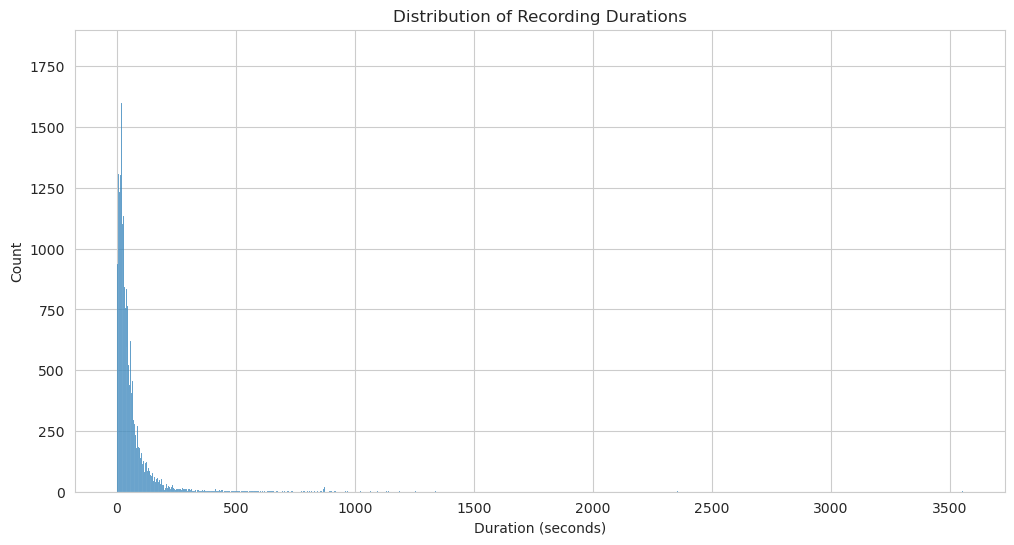

In [138]:
plt.figure(figsize=(12, 6))
sns.histplot(A_Z_df['duration']) #, kde=True)
plt.title('Distribution of Recording Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.show()

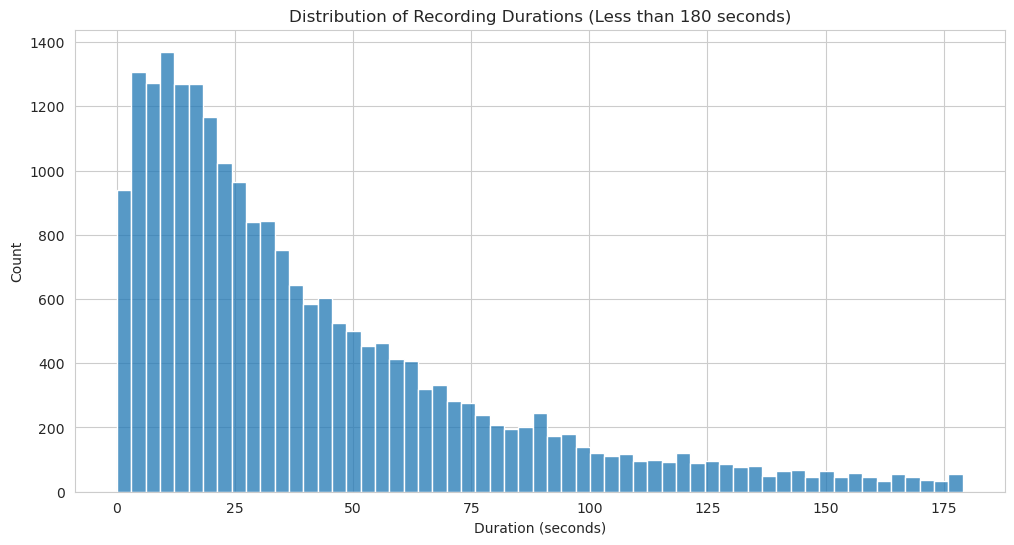

In [139]:
# only look at recordings less than 3 minutes

plt.figure(figsize=(12, 6))
sns.histplot(A_Z_df[A_Z_df['duration'] < 180]['duration']) #, kde=True)
plt.title('Distribution of Recording Durations (Less than 180 seconds)')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.show()

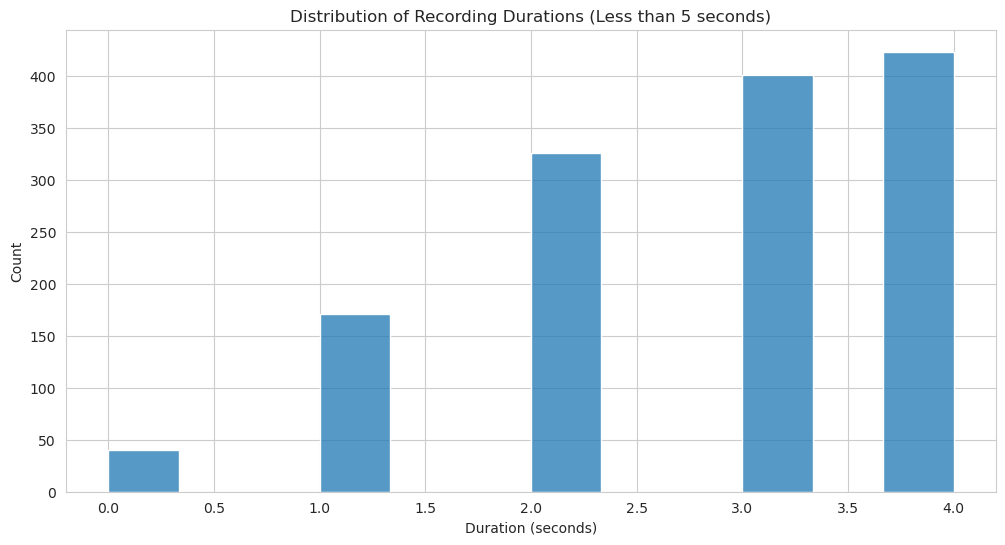

In [140]:
# only look at recordings less than 5 seconds

plt.figure(figsize=(12, 6))
sns.histplot(A_Z_df[A_Z_df['duration'] < 5]['duration']) #, kde=True)
plt.title('Distribution of Recording Durations (Less than 5 seconds)')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.show()

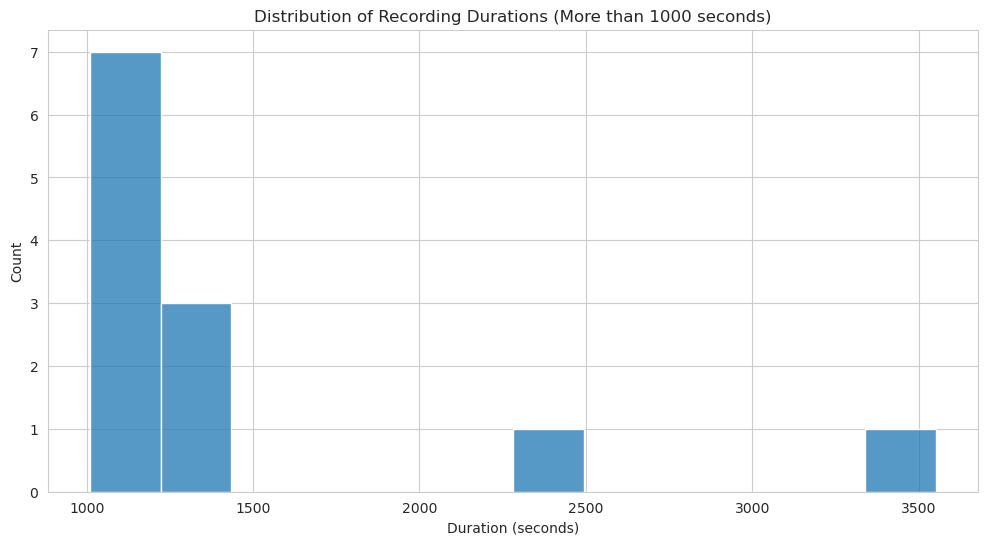

In [141]:
# only look at recordings more than 1000 seconds

plt.figure(figsize=(12, 6))
sns.histplot(A_Z_df[A_Z_df['duration'] > 1000]['duration']) #, kde=True)
plt.title('Distribution of Recording Durations (More than 1000 seconds)')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.show()

In [142]:
min_duration = A_Z_df['duration'].min()
max_duration = A_Z_df['duration'].max()
mode_duration = A_Z_df['duration'].mode()[0]
print(f'The minimum duration of recording is {min_duration}')
print(f'The maximum duration of recording is {max_duration}')
print(f'The most common duration of recording is {mode_duration}')

The minimum duration of recording is 0
The maximum duration of recording is 3552
The most common duration of recording is 10


# (Graphical Univariate Analysis)

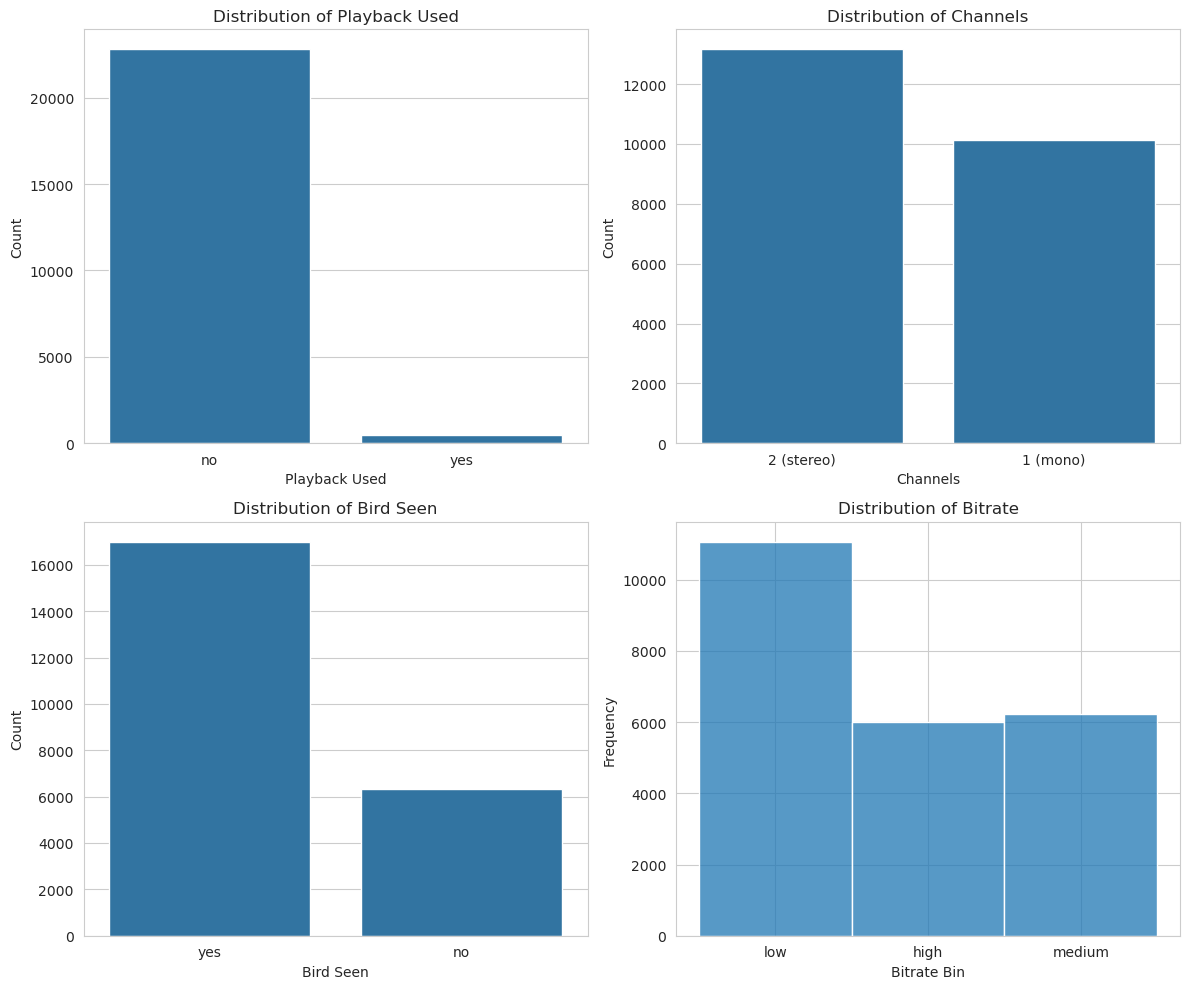

In [143]:
fig, axes = plt.subplot_mosaic(
    [['A', 'B'],
     ['C', 'D']],
    figsize=(12, 10)
)

# Playback Used
sns.countplot(data=A_Z_df, x='playback_used', ax=axes['A'])
axes['A'].set_title('Distribution of Playback Used')
axes['A'].set_xlabel('Playback Used')
axes['A'].set_ylabel('Count')

# Channels
sns.countplot(data=A_Z_df, x='channels', ax=axes['B'])
axes['B'].set_title('Distribution of Channels')
axes['B'].set_xlabel('Channels')
axes['B'].set_ylabel('Count')

# Bird Seen
sns.countplot(data=A_Z_df, x='bird_seen', ax=axes['C'])
axes['C'].set_title('Distribution of Bird Seen')
axes['C'].set_xlabel('Bird Seen')
axes['C'].set_ylabel('Count')

# Bitrate
sns.histplot(A_Z_df['bitrate_bin'], ax=axes['D'])
axes['D'].set_title('Distribution of Bitrate')
axes['D'].set_xlabel('Bitrate Bin')
axes['D'].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

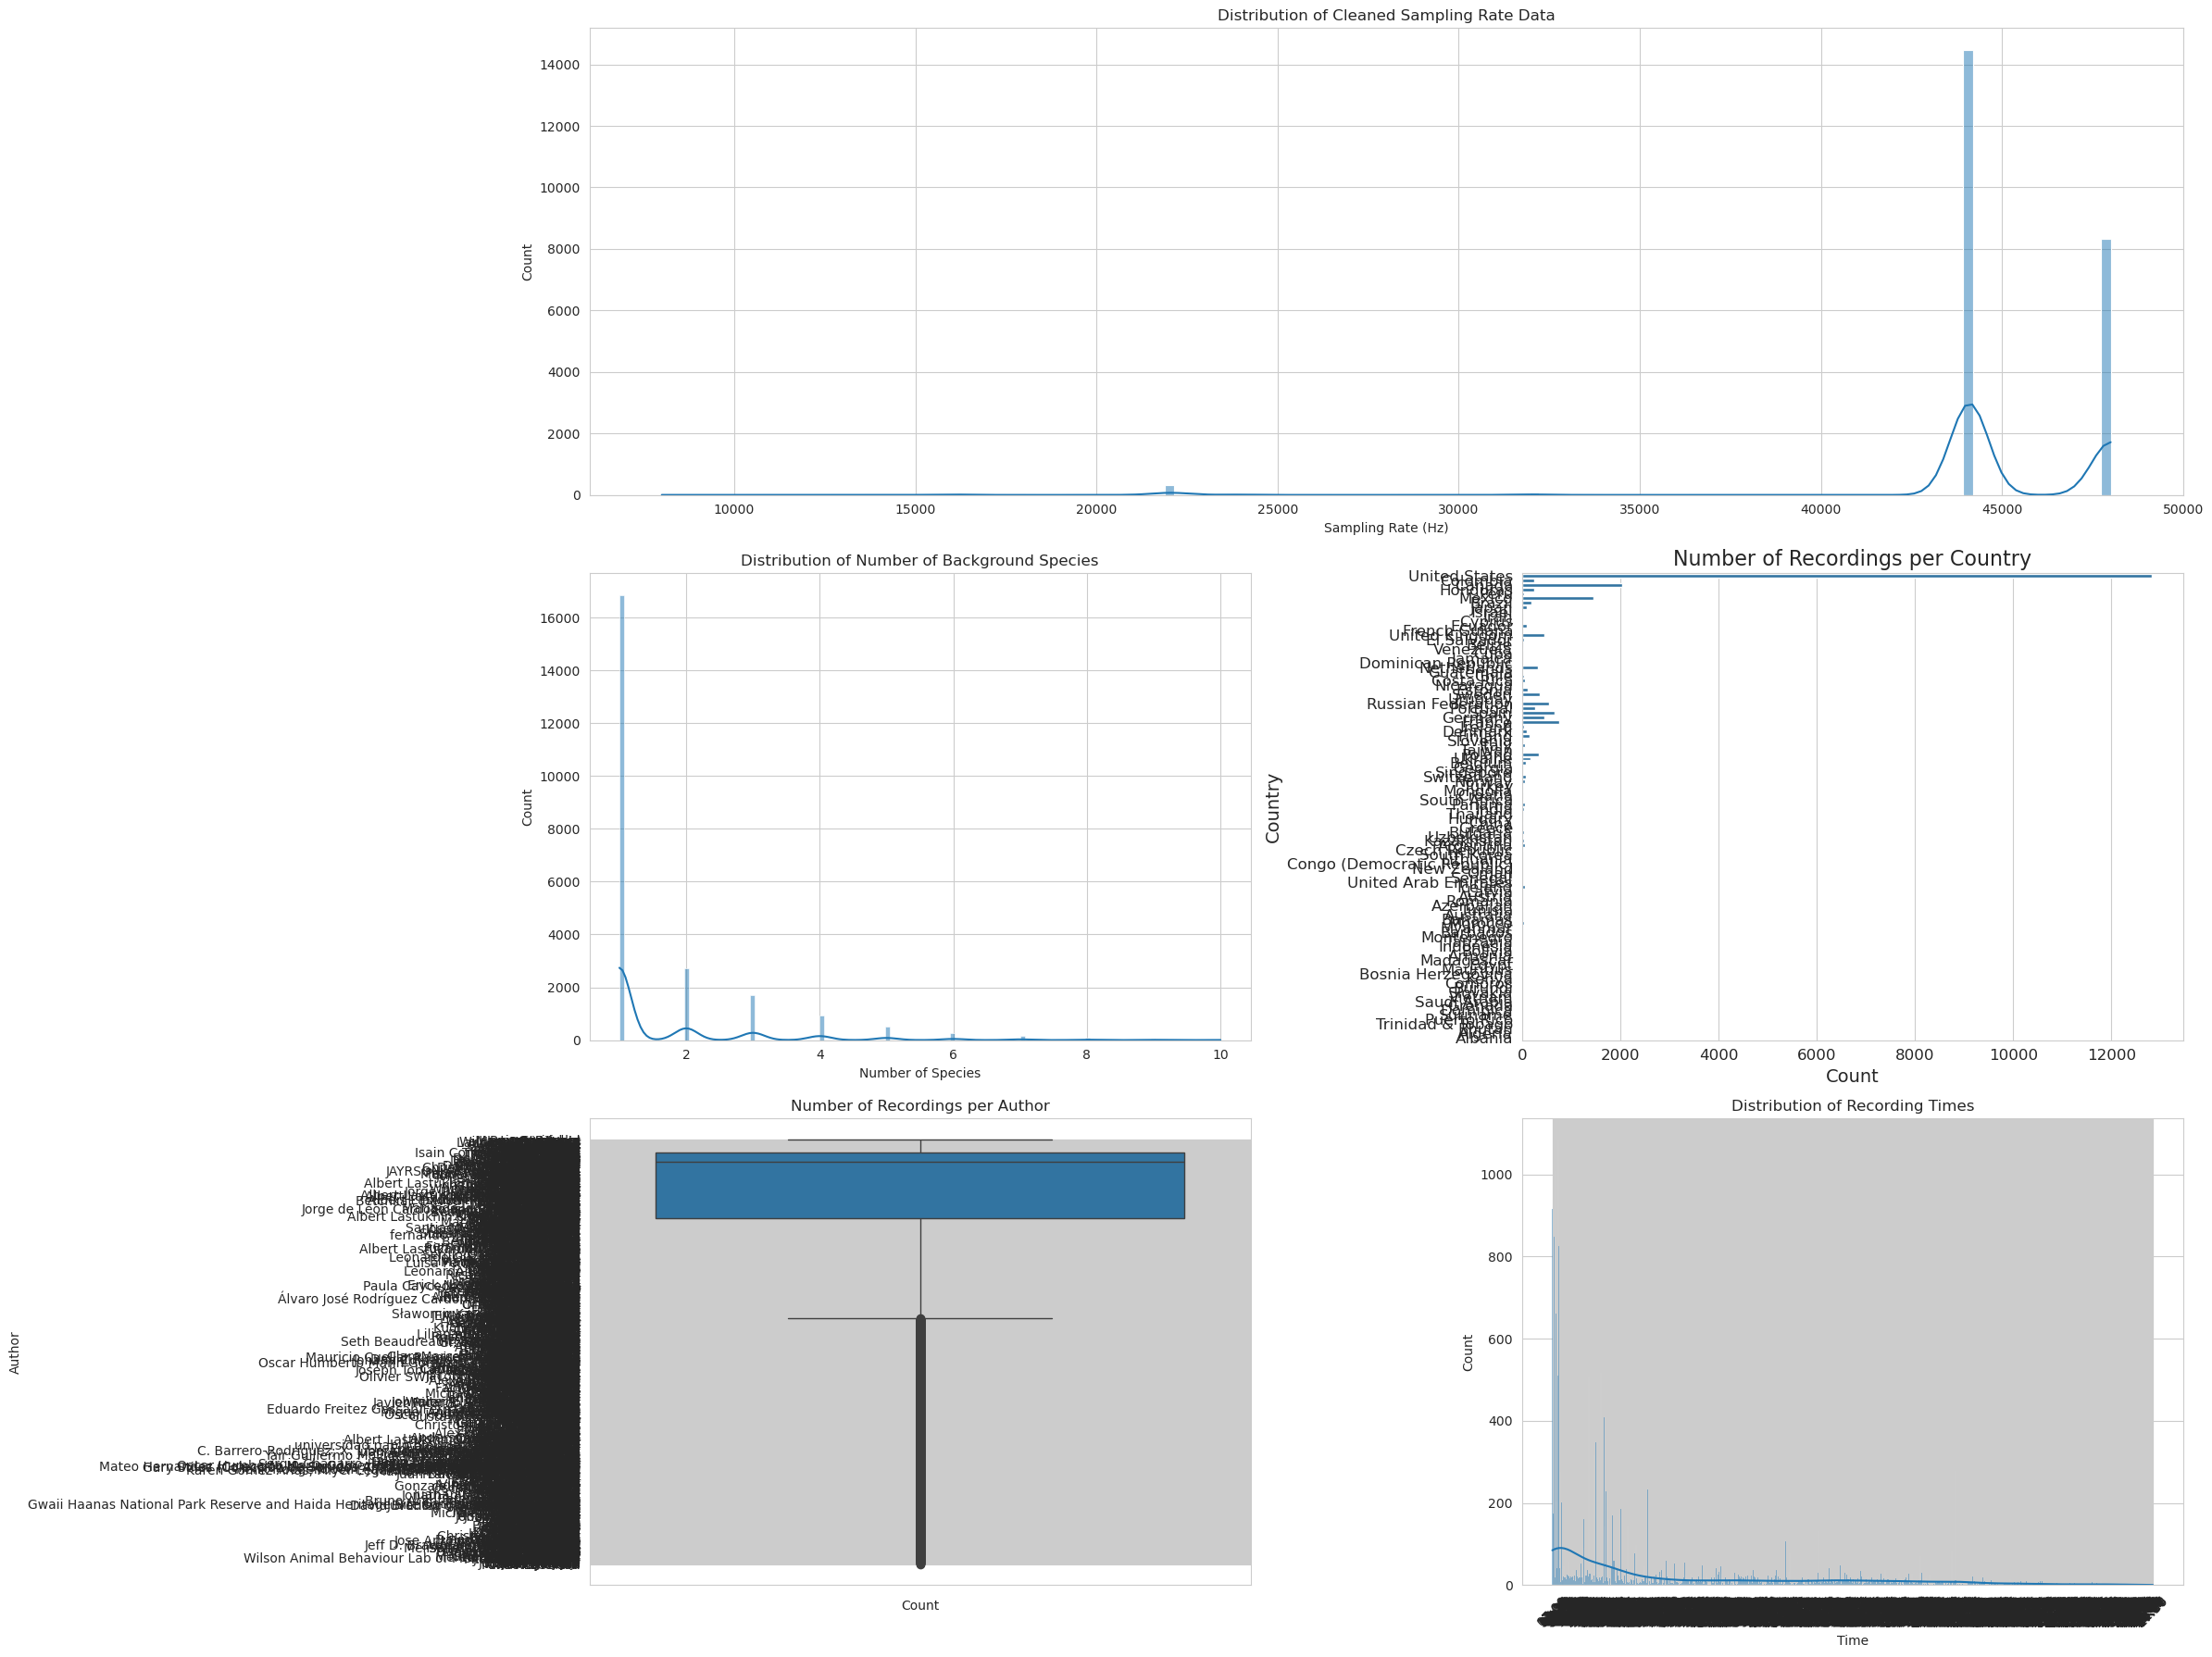

In [144]:
fig, axes = plt.subplot_mosaic(
    [['A', 'A'],
     ['B', 'C'],
     ['D', 'E']],
    figsize=(24, 18)
)

# Sampling Rate
sns.histplot(A_Z_df['sampling_rate_cleaned'], kde=True, ax=axes['A'])
axes['A'].set_title('Distribution of Cleaned Sampling Rate Data')
axes['A'].set_xlabel('Sampling Rate (Hz)')
axes['A'].set_ylabel('Count')

# Background Species
sns.histplot(A_Z_df['num_species'][A_Z_df['num_species'] < 11], kde=True, ax=axes['B'])
axes['B'].set_title('Distribution of Number of Background Species')
axes['B'].set_xlabel('Number of Species')
axes['B'].set_ylabel('Count')

# Country
sns.countplot(data=A_Z_df, y='country', ax=axes['C'])
axes['C'].set_title('Number of Recordings per Country', fontsize=16)
axes['C'].set_xlabel('Count', fontsize=14)
axes['C'].set_ylabel('Country', fontsize=14)
axes['C'].tick_params(axis='x', labelsize=12)
axes['C'].tick_params(axis='y', labelsize=12)

# Author
sns.boxplot(y=A_Z_df['author'], ax=axes['D'])
axes['D'].set_title('Number of Recordings per Author')
axes['D'].set_ylabel('Author')
axes['D'].set_xlabel('Count')

# Time of Day
sns.histplot(A_Z_df['time'], kde=True, ax=axes['E'])
axes['E'].set_title('Distribution of Recording Times')
axes['E'].set_xlabel('Time')
axes['E'].set_ylabel('Count')
axes['E'].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


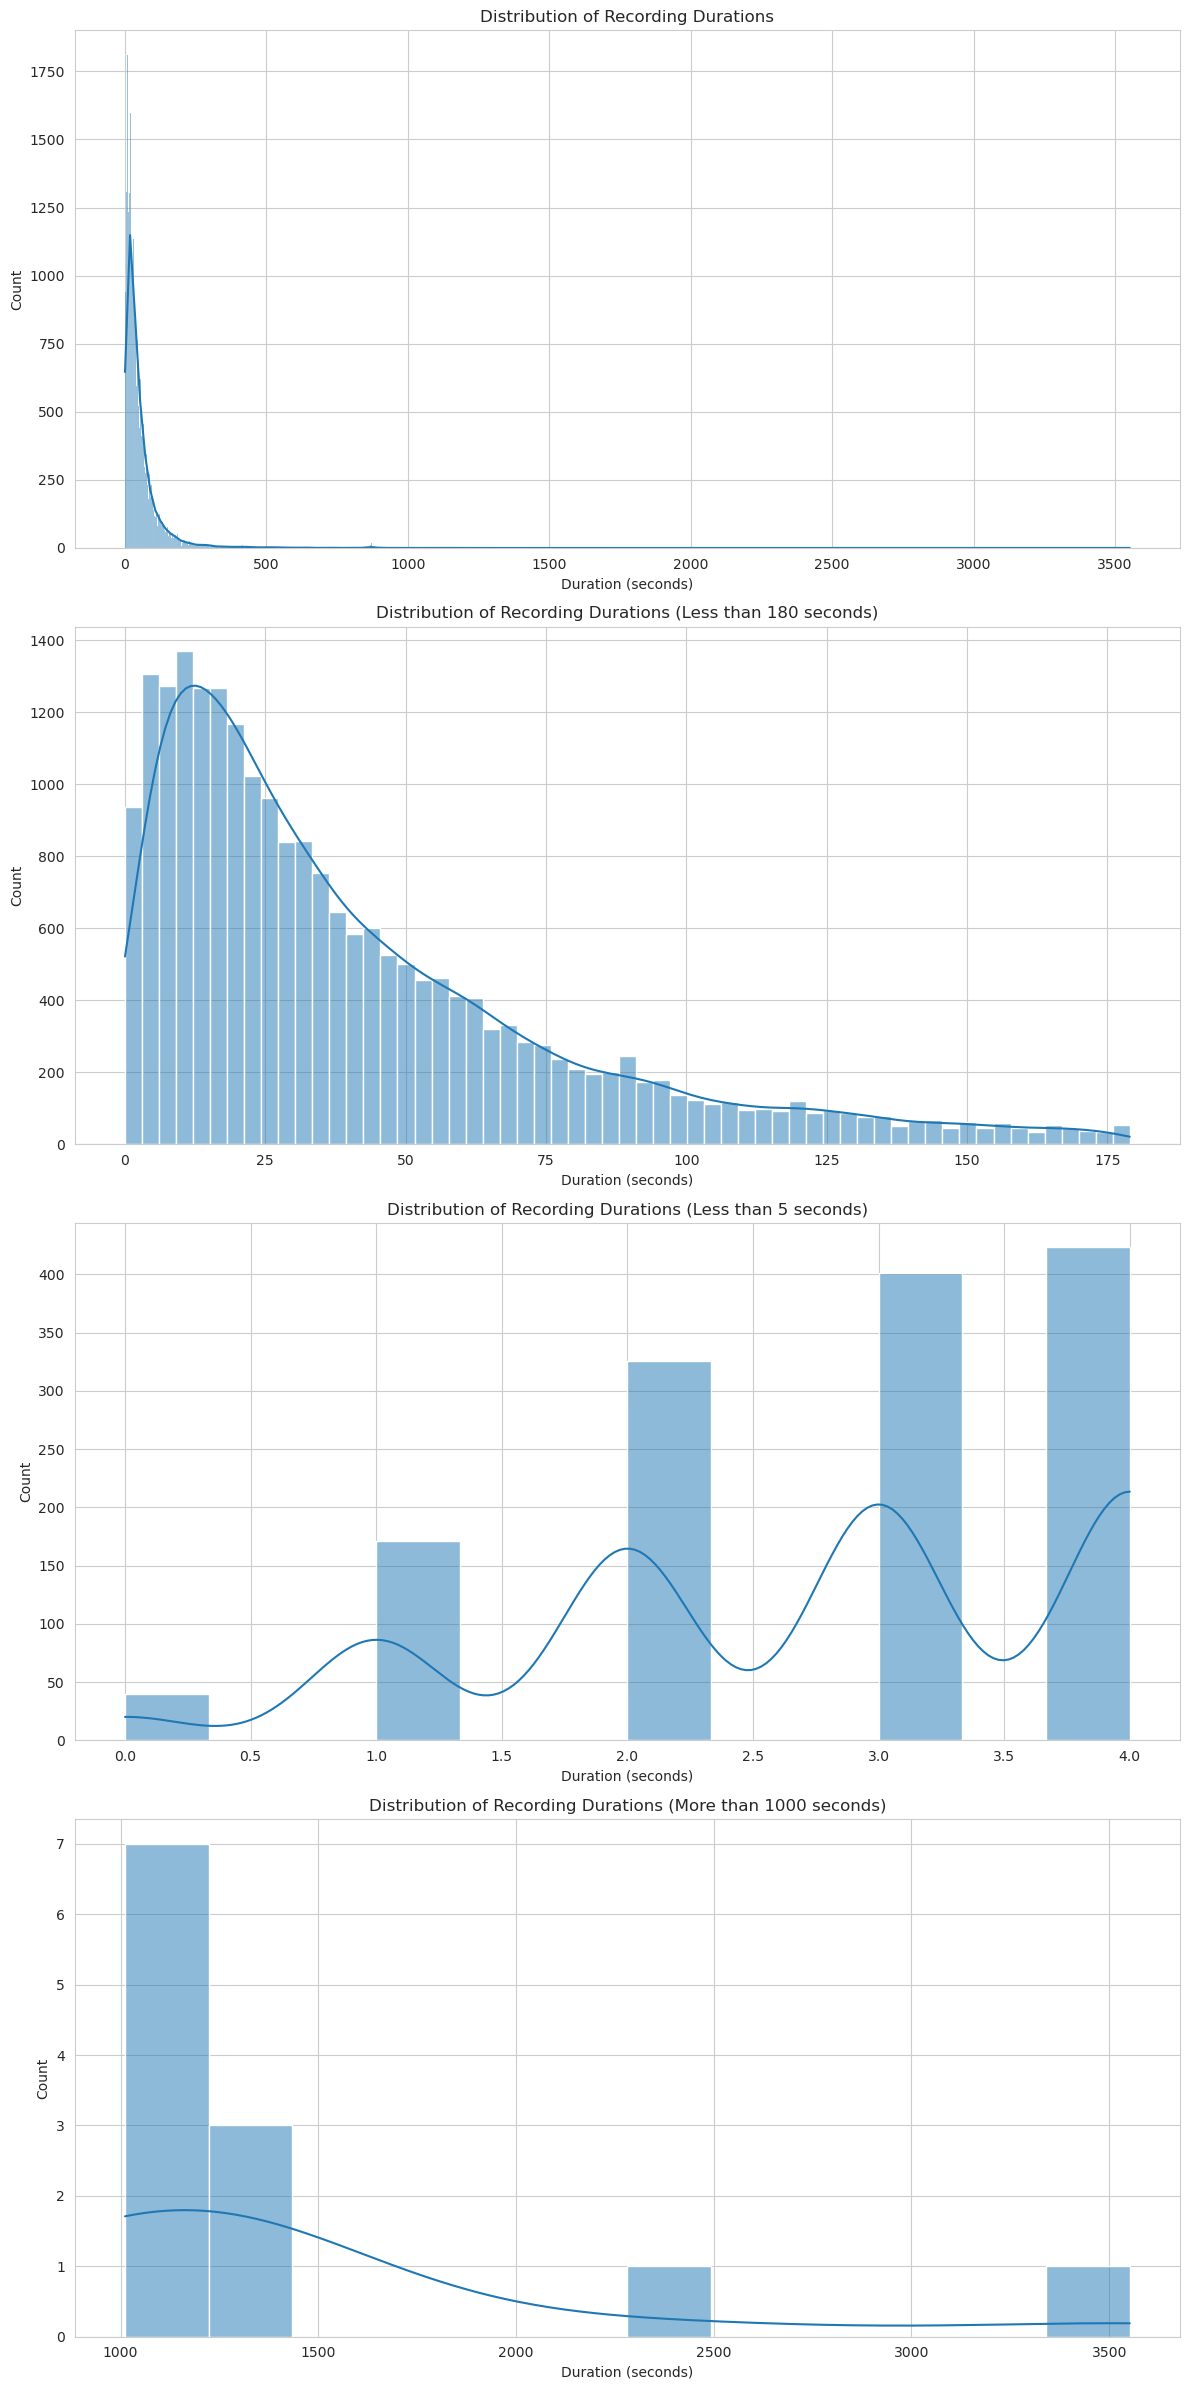

In [145]:
fig, axes = plt.subplot_mosaic(
    [['A'],
     ['B'],
     ['C'],
     ['D']],
    figsize=(12, 24)
)

# Duration
sns.histplot(A_Z_df['duration'], kde=True, ax=axes['A'])
axes['A'].set_title('Distribution of Recording Durations')
axes['A'].set_xlabel('Duration (seconds)')
axes['A'].set_ylabel('Count')

# Recordings less than 3 minutes
sns.histplot(A_Z_df[A_Z_df['duration'] < 180]['duration'], kde=True, ax=axes['B'])
axes['B'].set_title('Distribution of Recording Durations (Less than 180 seconds)')
axes['B'].set_xlabel('Duration (seconds)')
axes['B'].set_ylabel('Count')

# Recordings less than 5 seconds
sns.histplot(A_Z_df[A_Z_df['duration'] < 5]['duration'], kde=True, ax=axes['C'])
axes['C'].set_title('Distribution of Recording Durations (Less than 5 seconds)')
axes['C'].set_xlabel('Duration (seconds)')
axes['C'].set_ylabel('Count')

# Recordings more than 1000 seconds
sns.histplot(A_Z_df[A_Z_df['duration'] > 1000]['duration'], kde=True, ax=axes['D'])
axes['D'].set_title('Distribution of Recording Durations (More than 1000 seconds)')
axes['D'].set_xlabel('Duration (seconds)')
axes['D'].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Non-Graphical Univariate Analysis

In [146]:
# removeing ' (Hz)' in each row --> converting to integers
A_Z_df['sampling_rate'] = A_Z_df['sampling_rate'].str.replace(' (Hz)', '').astype(int)

# numerical features
numerical_features = ['bitrate_of_mp3', 'duration', 'elevation', 'latitude', 'longitude', 'rating', 'sampling_rate']

# summary statistics
summary_stats_numerical = A_Z_df[numerical_features].describe()

# mode
mode_stats_numerical = A_Z_df[numerical_features].mode().iloc[0]

# variance and standard deviation
variance_numerical = A_Z_df[numerical_features].var()
std_dev_numerical = A_Z_df[numerical_features].std()

# range
range_stats_numerical = A_Z_df[numerical_features].max() - A_Z_df[numerical_features].min()

In [147]:
summary_stats_numerical

bitrate_of_mp3      duration     elevation      latitude     longitude  \
count    23316.000000  23316.000000  23316.000000  23316.000000  23316.000000   
mean    188740.521873     54.415552    576.977783     39.003196    -70.523010   
std      84457.590721     85.607875    784.450028     14.462462     56.883246   
min      16000.000000      0.000000  -3670.000000    -51.721100   -165.405300   
25%     128000.000000     15.000000     30.000000     33.384650   -112.330500   
50%     140598.000000     31.000000    200.000000     40.605200    -87.096450   
75%     319998.000000     63.000000    900.000000     47.701000    -47.740100   
max     320202.000000   3552.000000   7760.000000     78.197100    179.360700   

             rating  sampling_rate  
count  23316.000000   23316.000000  
mean       3.268828   45008.484517  
std        1.214785    3942.039064  
min        0.000000    8000.000000  
25%        2.500000   44100.000000  
50%        3.500000   44100.000000  
75%        4.000000   48000.000000  
max        5.000000   48000.000000

In [148]:
# merging
numerical_stats = pd.concat([mode_stats_numerical, variance_numerical, std_dev_numerical, range_stats_numerical], axis=1)
# renaming columns
numerical_stats.columns = ['mode', 'variance', 'std_dev', 'range']
numerical_stats

mode      variance       std_dev        range
bitrate_of_mp3  128000.0000  7.133085e+09  84457.590721  304202.0000
duration            10.0000  7.328708e+03     85.607875    3552.0000
elevation            0.0000  6.153618e+05    784.450028   11430.0000
latitude            49.6340  2.091628e+02     14.462462     129.9182
longitude           26.2213  3.235704e+03     56.883246     344.7660
rating               3.5000  1.475702e+00      1.214785       5.0000
sampling_rate    44100.0000  1.553967e+07   3942.039064   40000.0000

In [149]:
categorical_features = ['playback_used', 'channels', 'bird_seen']

# Function to perform non-graphical univariate analysis on categorical features
def univariate_analysis(df, features):
    analysis_results = {}
    for feature in features:
        analysis_results[feature] = {
            "mode": df[feature].mode().iloc[0],
            "frequency_distribution": df[feature].value_counts()
        }
    return analysis_results

# Conduct the analysis
analysis_results = univariate_analysis(A_Z_df, categorical_features)

# Display the results
for feature, result in analysis_results.items():
    print(f"\nFeature: {feature}")
    print(f"Mode: {result['mode']}")
    print(f"Frequency Distribution:\n{result['frequency_distribution']}")


Feature: playback_used
Mode: no
Frequency Distribution:
playback_used
no     22819
yes      497
Name: count, dtype: int64

Feature: channels
Mode: 2 (stereo)
Frequency Distribution:
channels
2 (stereo)    13172
1 (mono)      10144
Name: count, dtype: int64

Feature: bird_seen
Mode: yes
Frequency Distribution:
bird_seen
yes    17004
no      6312
Name: count, dtype: int64


In [150]:
categorical_features = ['date']

# Function to perform non-graphical univariate analysis on categorical features
def univariate_analysis(df, features):
    analysis_results = {}
    for feature in features:
        analysis_results[feature] = {
            "mode": df[feature].mode().iloc[0],
            "frequency_distribution": df[feature].value_counts()
        }
    return analysis_results

# Conduct the analysis
analysis_results = univariate_analysis(A_Z_df, categorical_features)

# Display the results
for feature, result in analysis_results.items():
    print(f"\nFeature: {feature}")
    print(f"Mode: {result['mode']}")
    print(f"Frequency Distribution:\n{result['frequency_distribution']}")


Feature: date
Mode: 2020-07-19 00:00:00
Frequency Distribution:
date
2020-07-19    86
2020-05-21    74
2020-04-25    68
2018-06-08    66
2020-04-19    60
              ..
2012-09-16     1
2011-10-03     1
1997-06-09     1
2009-11-29     1
2005-03-23     1
Name: count, Length: 3651, dtype: int64


In [151]:
categorical_features = ['time']

# Function to perform non-graphical univariate analysis on categorical features
def univariate_analysis(df, features):
    analysis_results = {}
    for feature in features:
        analysis_results[feature] = {
            "mode": df[feature].mode().iloc[0],
            "frequency_distribution": df[feature].value_counts()
        }
    return analysis_results

# Conduct the analysis
analysis_results = univariate_analysis(A_Z_df, categorical_features)

# Display the results
for feature, result in analysis_results.items():
    print(f"\nFeature: {feature}")
    print(f"Mode: {result['mode']}")
    print(f"Frequency Distribution:\n{result['frequency_distribution']}")


Feature: time
Mode: 08:00
Frequency Distribution:
time
08:00    1082
09:00    1008
07:00     915
10:00     849
07:30     847
         ... 
21:53       1
01:38       1
23:03       1
22:14       1
03:59       1
Name: count, Length: 1272, dtype: int64


In [152]:
categorical_features = ['species']

# Function to perform non-graphical univariate analysis on categorical features
def univariate_analysis(df, features):
    analysis_results = {}
    for feature in features:
        analysis_results[feature] = {
            "mode": df[feature].mode().iloc[0],
            "frequency_distribution": df[feature].value_counts()
        }
    return analysis_results

# Conduct the analysis
analysis_results = univariate_analysis(A_Z_df, categorical_features)

# Display the results
for feature, result in analysis_results.items():
    print(f"\nFeature: {feature}")
    print(f"Mode: {result['mode']}")
    print(f"Frequency Distribution:\n{result['frequency_distribution']}")


Feature: species
Mode: Red Crossbill
Frequency Distribution:
species
Red Crossbill                1758
House Sparrow                1208
House Wren                    945
Northern Raven                878
Common Starling               688
                             ... 
Ring-necked Duck                1
Bufflehead                      1
Hooded Merganser                1
Black-chinned Hummingbird       1
Ruffed Grouse                   1
Name: count, Length: 259, dtype: int64


In [153]:
categorical_features = ['country']

# Function to perform non-graphical univariate analysis on categorical features
def univariate_analysis(df, features):
    analysis_results = {}
    for feature in features:
        analysis_results[feature] = {
            "mode": df[feature].mode().iloc[0],
            "frequency_distribution": df[feature].value_counts()
        }
    return analysis_results

# Conduct the analysis
analysis_results = univariate_analysis(A_Z_df, categorical_features)

# Display the results
for feature, result in analysis_results.items():
    print(f"\nFeature: {feature}")
    print(f"Mode: {result['mode']}")
    print(f"Frequency Distribution:\n{result['frequency_distribution']}")


Feature: country
Mode: United States
Frequency Distribution:
country
United States    12821
Canada            2048
Mexico            1451
France             753
Spain              658
                 ...  
Barbados             1
Armenia              1
Comoros              1
Burundi              1
Albania              1
Name: count, Length: 102, dtype: int64


In [154]:
categorical_features = ['author']

# Function to perform non-graphical univariate analysis on categorical features
def univariate_analysis(df, features):
    analysis_results = {}
    for feature in features:
        analysis_results[feature] = {
            "mode": df[feature].mode().iloc[0],
            "frequency_distribution": df[feature].value_counts()
        }
    return analysis_results

# Conduct the analysis
analysis_results = univariate_analysis(A_Z_df, categorical_features)

# Display the results
for feature, result in analysis_results.items():
    print(f"\nFeature: {feature}")
    print(f"Mode: {result['mode']}")
    print(f"Frequency Distribution:\n{result['frequency_distribution']}")


Feature: author
Mode: Richard E. Webster
Frequency Distribution:
author
Richard E. Webster    1652
Paul Marvin            930
Thomas Magarian        905
Bobby Wilcox           682
Manuel Grosselet       565
                      ... 
Robin Sommerfeld         1
Leszek Matacz            1
Mario                    1
Michele Peron            1
François Grimal          1
Name: count, Length: 1469, dtype: int64
